# FIFA-MoneyBall project

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from math import sqrt
pd.set_option('display.max_rows', 500)

In [2]:
# Functions for processing
def import_to_df(csv_file):
    df = pd.read_csv(csv_file)
#     df = df.drop(['Unnamed: 0'], axis = 1)
    return df
  

# 03 - Cleaning/Wrangling/EDA
    # Change column names.
    
def reformat_columns(df):
    df_copy = df.copy()
    df_copy.columns = df_copy.columns.str.lower().str.replace(' ', '_')
    return df_copy   
    
    # Deal with NaN values.
    
def convert_to_euros(value):
    if value.endswith('M'):
        return float(value[:-1]) * 1000000
    elif value.endswith('K'):
        return float(value[:-1]) * 1000
    else:
        return value
    
def check_nan_values(df):
    null_df = df.isna().sum()/len(df)*100
    print('The percentage of NaN values per column is:\n',null_df)
    
def remove_nan_cols(df, percentage_nan):
    df_copy = df.copy()
    null_df = df.isna().sum()/len(df)*100
    for item in null_df.index:
        if null_df.loc[item] > percentage_nan:
            df_copy.drop([item], inplace=True, axis=1)
            print("Dropping column:", item, "due to percentage of NaN values greater than:", percentage_nan) 
    return df_copy  

def remove_nan_rows(df):
    df_copy = df.copy()
    return df_copy.dropna()

# 03 - Cleaning/Wrangling/EDA
    # Outliers???
# def filter_outliers(df, threshold):
#     mask = pd.Series(data=True, index=df.index)
#     for col in df.columns:
#         q1 = df[col].quantile(0.25)
#         q3 = df[col].quantile(0.75)
#         iqr = q3 - q1
#         lower_limit = q1 - (threshold * iqr)
#         upper_limit = q3 + (threshold * iqr)
#         col_mask = (df[col] >= lower_limit) & (df[col] <= upper_limit)
#         mask = mask & col_mask
#     return df[mask]
    
    # Categorical Features. Numerical Features.
    
def to_object(df, col1, col2):
    df[col1] = df[col1].astype(str)
    df[col2] = df[col2].astype(str)
    return df   
    
def split_categorical_numerical(df):
    categorical_df = df.select_dtypes(include=['object'])
    numerical_df = df.select_dtypes(exclude=['object'])
    return categorical_df, numerical_df
    
    # Exploration.
        
# 04 - Processing Data
    # Dealing with outliers.
    # Normalization.
    
def split_numerical(numerical_df, y_var):
    df_copy = numerical_df.copy()
    x = df_copy.drop(y_var, axis=1)
    y = df_copy[y_var]
    return x,y

# ax = sns.scatterplot(x = 'ova', y = 'pot', data=df_numeric_filtered)

def plot_scatter(df):
    num_cols = len(df.columns)
    num_subplots = num_cols // 2 + num_cols % 2
    fig, axis = plt.subplots(2,num_subplots, figsize=(12,8))  
    axis = axis.ravel()
#     pal = {"1★": "#4575B4", "2★": "#AED6F1", "3★": "#FEE090", "4★": "#FC8D59" , "5★": "#D73027"}
    for i, col in enumerate(df.columns):
        sns.scatterplot(x = df[col], y = 'pot', data=df, ax = axis[i]).set_xlabel(col)    
    plt.tight_layout()
    plt.show()

def plot_hist(df):
    num_cols = len(df.columns)
    num_subplots = num_cols // 2 + num_cols % 2
    fig, axis = plt.subplots(2,num_subplots, figsize=(12,8))  
    axis = axis.ravel()
    for i, col in enumerate(df.columns):
        sns.histplot(df[col], kde=True, ax = axis[i]).set_xlabel(col)     
    plt.tight_layout()
    plt.show()

def plot_categorical_histograms(df, cat_cols):
    num_cols = len(cat_cols)
    num_subplots = num_cols // 2 + num_cols % 2
    fig, axis = plt.subplots(2,num_subplots, figsize=(12,8))  
    axis = axis.ravel()
    
    for i, (col,ax) in enumerate(zip(cat_cols, axis)):
        sns.histplot(data=df, x='pot', hue=col, stat='count', multiple='stack', ax=ax)   
        axis[i].set_xlabel(col)
        axis[i].set_ylabel("Percent")
        axis[i].set_title(f"Stacked Histogram of {col} by Potential")
    plt.tight_layout()
    plt.show()    
    
    
def plot_box(df):
    num_cols = len(df.columns)
    num_subplots = num_cols // 2 + num_cols % 2
    fig, axis = plt.subplots(2,num_subplots, figsize=(12,8))  
    axis = axis.ravel()
    for i, col in enumerate(df.columns):
        sns.boxplot(x = df[col], ax = axis[i]).set_xlabel(col)     
    plt.tight_layout()
    plt.show() 
    
def replace_inf(i):
    if np.isfinite(i):
        return i
    else:
        return np.NAN    
    
def log_transformer(df, cols_to_log):
    df_copy = df.copy()
    for col in cols_to_log:
        df_copy[col] = np.log(df_copy[col])
        df_copy[col] = list(map(replace_inf, df_copy[col]))
        df_copy[col] = df_copy[col].fillna(df_copy[col].mean())
    return df_copy

def box_cox_transformer(df, cols_to_transform):
    df_copy = df.copy()
    for col in cols_to_transform:
        df_copy[col] = np.where(df_copy[col] <= 0, 0, df_copy[col])
        df_copy[col].replace(0,df[col].mean(), inplace=True)
        transformed_col, _ = stats.boxcox(df_copy[col])
        df_copy[col] = transformed_col
    return df_copy

def min_max_scaler(df):
    df_copy = pd.DataFrame(MinMaxScaler().fit(df).transform(df))
    return df_copy

def standard_scaler(df):
    columns = df.columns
    df_copy = pd.DataFrame(StandardScaler().fit(df).transform(df))
    df_copy.columns = columns
    return df_copy

    # Encoding Categorical Data.
    # Splitting into train set and test set.    
def categorical_correlation(df, CAT_COLS):
    for col in CAT_COLS:
        grouped_data= df.dropna().groupby(col)['pot'].mean()
        correlation_coefficient = grouped_data.corr(df.dropna()[col])
        print(grouped_data)
        print(correlation_coefficient)


def label_encoder(df, label_encoder_cols):
    df_copy = df.copy()
    for col in label_encoder_cols:
        df_copy[col] = LabelEncoder().fit(df_copy[col]).transform(df_copy[col])
    return df_copy

def one_hot_encoder(df, one_hot_cols):
    df_encoded = df.copy()
    encoder = OneHotEncoder()
    encoder.fit(df_encoded[one_hot_cols].values)
    encoded = encoder.transform(df_encoded[one_hot_cols].values)
    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(one_hot_cols))
    df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
    df_encoded = df_encoded.drop(one_hot_cols, axis=1)
    return df_encoded       
        
def concat_df(df1, df2):
    df2 = df2.reset_index(drop=True)
    df_combined = pd.concat([df1, df2], axis=1, ignore_index=True)
    df_combined = sm.add_constant(df_combined)
    return df_combined

# def train_test_split(X, y, test_size=0.4, random_state=50):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=random_state)
#     return X_train, y_train, X_test, y_test

def linear_regression(X, y):
    X = sm.add_constant(X) # Add a constant tern to the input data
    model = sm.OLS(y, X).fit()
    return model

def make_predictions(model, data):
    data = sm.add_constant(data) # Add a constant tern to the input data
    predictions = model.predict(data)
    return predictions
    
                   
def model_metrics(X, y, model):
    X = sm.add_constant(X) # Add a constant tern to the input data
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    print('R2 Score: {:.3f}'.format(r2), '\nMean Squared Error: {:.3f}'.format(mse), '\nRoot MSE: {:.3f}'.format(rmse), '\nMean Absolute Error: {:.3f}'.format(mae) )


## Loading the raw data

In [3]:
df = import_to_df('fifa21_male2.csv')
print(df.shape)
df.head(50)

(17125, 107)


C:\Users\pgarciag\AppData\Local\Temp\ipykernel_2508\1436763483.py:3: DtypeWarning: Columns (78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


ID             Name  Age  OVA            Nationality  \
0      2      G. Pasquale   33   69                  Italy   
1     16      Luis García   37   71                  Spain   
2     27          J. Cole   33   71                England   
3     36         D. Yorke   36   68  Trinidad &amp; Tobago   
4     41          Iniesta   36   81                  Spain   
5     61       D. Odonkor   27   66                Germany   
6     80     E. Belözoğlu   38   77                 Turkey   
7    241         R. Giggs   39   78                  Wales   
8    244    G. Neville  B   35   76                England   
9    246       P. Scholes   37   80                England   
10   249       P. Neville   35   74                England   
11   250       D. Beckham   37   78                England   
12   330         R. Keane   35   80    Republic of Ireland   
13   388      S. Campbell   35   75                England   
14   488          O. Kahn   38   87                Germany   
15   496        D. Hamann   36   61                Germany   
16   570        A. Okocha   33   73                Nigeria   
17   670             Zulu   26   66                 Brazil   
18   684     M. Schwarzer   42   73              Australia   
19   805       J. Lehmann   39   79                Germany   
20  1001        G. Király   39   69                Hungary   
21  1040   Roberto Carlos   38   79                 Brazil   
22  1041       J. Zanetti   39   75              Argentina   
23  1075     A. Del Piero   38   70                  Italy   
24  1088         A. Nesta   37   73                  Italy   
25  1109       P. Maldini   40   77                  Italy   
26  1179        G. Buffon   42   82                  Italy   
27  1183     F. Cannavaro   35   82                  Italy   
28  1186            Couto   37   82               Portugal   
29  1198       F. Inzaghi   37   73                  Italy   
30  1219       C. Abbiati   37   75                  Italy   
31  1222      Marco Paulo   35   61               Portugal   
32  1238         F. Totti   39   80                  Italy   
33  1256       C. Seedorf   37   82            Netherlands   
34  1419        P. Vieira   34   76                 France   
35  1615        L. Thuram   35   83                 France   
36  1625         T. Henry   36   79                 France   
37  1668      C. Makélelé   37   74                 France   
38  1747        G. Coupet   37   75                 France   
39  1845      O. Solskjær   34   75                 Norway   
40  2062        L. Bowyer   34   69                England   
41  2147  M. Stekelenburg   37   72            Netherlands   
42  2148      H. Trabelsi   29   79                Tunisia   
43  2196  R. Weidenfeller   36   75                Germany   
44  2231        E. Heskey   37   66                England   
45  2492           Eliseu   33   76               Portugal   
46  2651         S. Given   40   73    Republic of Ireland   
47  2702       K. Ellison   41   58                England   
48  2837         R. Delap   36   63    Republic of Ireland   
49  2956        S. Petrov   32   76               Bulgaria   

                     Club  BOV   BP      Position  \
0                 Udinese   71  LWB            LM   
1               KAS Eupen   70   CM    CM CAM CDM   
2           Coventry City   71  CAM  CAM RM RW LM   
3              Sunderland   70   ST           NaN   
4             Vissel Kobe   82  CAM        CM CAM   
5        Alemannia Aachen   66   RW         RW RM   
6           Fenerbahçe SK   77   CM        CM CDM   
7       Manchester United   78  CAM     LM CM CAM   
8       Manchester United   78   CB     RB CB RWB   
9       Manchester United   82  CAM        CM CDM   
10                Everton   75   CB     CDM CM RB   
11                    NaN   77   CM         CM RM   
12              LA Galaxy   81   CF            ST   
13       Newcastle United   75   CB           NaN   
14      FC Bayern München   87   GK            G

## Data Preprocessing

In [4]:
#Reformat columns to lower case and remove spaces
df = reformat_columns(df)

In [5]:
df.describe().T

count           mean           std    min       25%  \
id                17125.0  219388.716204  37499.197507    2.0  204082.0   
age               17125.0      25.272934      4.942665   16.0      21.0   
ova               17125.0      66.965022      6.864329   38.0      62.0   
bov               17125.0      67.900204      6.637538   42.0      64.0   
pot               17125.0      72.489810      5.769949   47.0      69.0   
growth            17125.0       5.524788      5.787539   -1.0       0.0   
attacking         17125.0     258.537752     72.255687   33.0     232.0   
crossing          17125.0      51.621314     17.875715    6.0      41.0   
finishing         17125.0      47.956672     19.391547    3.0      33.0   
heading_accuracy  17125.0      53.598832     16.947164    5.0      46.0   
short_passing     17125.0      60.507620     13.960635    7.0      56.0   
volleys           17067.0      45.005742     17.729483    4.0      32.0   
skill             17125.0     266.607591     76.809344   43.0     232.0   
dribbling         17125.0      57.846423     18.047250    5.0      53.0   
curve             17067.0      49.574676     18.188344    4.0      37.0   
fk_accuracy       17125.0      44.387270     17.504128    5.0      32.0   
long_passing      17125.0      54.324321     14.856911    9.0      45.0   
ball_control      17125.0      60.642803     15.873647    5.0      57.0   
movement          17125.0     322.693664     54.933593  113.0     294.0   
acceleration      17125.0      65.445898     14.657889   12.0      58.0   
sprint_speed      17125.0      65.443036     14.437377   11.0      59.0   
agility           17067.0      64.602273     14.372443   14.0      57.0   
reactions         17125.0      62.924847      9.037279   24.0      57.0   
balance           17067.0      64.715591     14.031563   17.0      57.0   
power             17125.0     302.414774     49.380576  128.0     272.0   
shot_power        17125.0      59.711416     13.417931   12.0      50.0   
jumping           17067.0      65.170212     11.918063   22.0      58.0   
stamina           17125.0      63.309606     15.313272   11.0      56.0   
strength          17125.0      65.308555     12.627212   16.0      58.0   
long_shots        17125.0      49.135708     19.044862    4.0      35.0   
mentality         17125.0     261.922803     62.913935   50.0     235.0   
aggression        17125.0      56.997839     17.021619    9.0      45.0   
interceptions     17118.0      47.085582     20.846705    4.0      26.0   
positioning       17118.0      52.372766     19.094432    2.0      43.0   
vision            17067.0      55.443605     13.730080   10.0      47.0   
penalties         17125.0      50.251445     15.696363    7.0      40.0   
composure         16702.0      59.940965     11.751111   12.0      53.0   
defending         17125.0     141.469898     61.595180   17.0      84.0   
marking           17125.0      47.246949     20.182548    3.0      29.0   
standing_tackle   17125.0      48.279358     21.483597    5.0      28.0   
sliding_tackle    17067.0      46.099725     21.185154    6.0      25.0   
goalkeeping       17125.0      77.609693     81.136603    5.0      48.0   
gk_diving         17125.0      15.600467     16.828637    1.0       8.0   
gk_handling       17125.0      15.484672     16.143679    1.0       8.0   
gk_kicking        17125.0      15.472058     15.997328    1.0       8.0   
gk_positioning    17125.0      15.514277     16.406064    1.0       8.0   
gk_reflexes       17125.0      15.738628     17.130908    1.0       8.0   
total_stats       17125.0    1631.256175    260.357024  731.0    1492.0   
base_stats        17125.0     361.372146     40.252290  228.0     333.0   
pac               17125.0      68.091620     11.147116   25.0      62.0   
sho               17125.0      54.967299     13.877605   16.0      46.0   
pas               17125.0      58.926540     10.186728   25.0      52.0   
dri               17125.0      64.209869     

In [6]:
df.dtypes

id                    int64
name                 object
age                   int64
ova                   int64
nationality          object
club                 object
bov                   int64
bp                   object
position             object
player_photo         object
club_logo            object
flag_photo           object
pot                   int64
team_&_contract      object
height               object
weight               object
foot                 object
growth                int64
joined               object
loan_date_end        object
value                object
wage                 object
release_clause       object
contract             object
attacking             int64
crossing              int64
finishing             int64
heading_accuracy      int64
short_passing         int64
volleys             float64
skill                 int64
dribbling             int64
curve               float64
fk_accuracy           int64
long_passing          int64
ball_control        

In [7]:
# Change data types from Categorical to Numerical for the following columns: 'value', 'wage', 'release_clause', 'hits'
df['value'] = df.value.str.replace('€', '')
df['value']  = df.value.apply(convert_to_euros)

df['wage'] = df.wage.str.replace('€', '')
df['wage']  = df.wage.apply(convert_to_euros)

df['release_clause'] = df.release_clause.str.replace('€', '')
df['release_clause']  = df.release_clause.apply(convert_to_euros)

df['value'] = pd.to_numeric(df['value'], errors='coerce')
df['wage'] = pd.to_numeric(df['wage'], errors='coerce')
df['release_clause'] = pd.to_numeric(df['release_clause'], errors='coerce')
df['hits'] = pd.to_numeric(df['hits'], errors='coerce')

In [8]:
 # Deleting outliers
    
# df = df[df.value > 1000000]
# df.shape

In [9]:
df.dtypes

id                    int64
name                 object
age                   int64
ova                   int64
nationality          object
club                 object
bov                   int64
bp                   object
position             object
player_photo         object
club_logo            object
flag_photo           object
pot                   int64
team_&_contract      object
height               object
weight               object
foot                 object
growth                int64
joined               object
loan_date_end        object
value               float64
wage                float64
release_clause      float64
contract             object
attacking             int64
crossing              int64
finishing             int64
heading_accuracy      int64
short_passing         int64
volleys             float64
skill                 int64
dribbling             int64
curve               float64
fk_accuracy           int64
long_passing          int64
ball_control        

In [10]:
# Separate categorical and numerical columns

df_categorical = df.select_dtypes(include = 'object')
df_numeric = df.select_dtypes(exclude = 'object')

In [11]:
df_numeric.head(500)

id  age  ova  bov  pot  growth       value      wage  release_clause  \
0         2   33   69   71   69       0    625000.0    7000.0             0.0   
1        16   37   71   70   71       0    600000.0    7000.0       1100000.0   
2        27   33   71   71   71       0   1100000.0   15000.0             0.0   
3        36   36   68   70   82      14         0.0       0.0             0.0   
4        41   36   81   82   81       0   5500000.0   12000.0       7200000.0   
5        61   27   66   66   70       4    725000.0    5000.0             0.0   
6        80   38   77   77   77       0   2800000.0   44000.0       5300000.0   
7       241   39   78   78   78       0      1000.0   60000.0             0.0   
8       244   35   76   78   82       6         0.0       0.0             0.0   
9       246   37   80   82   80       0    400000.0   40000.0             0.0   
10      249   35   74   75   74       0    120000.0    7000.0             0.0   
11      250   37   78   77   78       0         0.0       0.0             0.0   
12      330   35   80   81   80       0   5500000.0   10000.0             0.0   
13      388   35   75   75   79       4         0.0       0.0             0.0   
14      488   38   87   87   90       3         0.0       0.0             0.0   
15      496   36   61   67   82      21         0.0       0.0             0.0   
16      570   33   73   76   90      17         0.0       0.0             0.0   
17      670   26   66   66   72       6         0.0       0.0             0.0   
18      684   42   73   73   73       0    500000.0   15000.0             0.0   
19      805   39   79   81   87       8         0.0       0.0             0.0   
20     1001   39   69   69   69       0         0.0       0.0             0.0   
21     1040   38   79   79   79       0         0.0   30000.0             0.0   
22     1041   39   75   75   75       0      1000.0   45000.0             0.0   
23     1075   38   70   74   70       0    190000.0   30000.0             0.0   
24     1088   37   73   72   73       0         0.0    6000.0             0.0   
25     1109   40   77   78   89      12         0.0       0.0             0.0   
26     1179   42   82   82   82       0   2200000.0   41000.0       3600000.0   
27     1183   35   82   82   89       7         0.0       0.0             0.0   
28     1186   37   82   82   84       2         0.0       0.0             0.0   
29     1198   37   73   72   73       0    350000.0   15000.0             0.0   
30     1219   37   75   75   75       0   1300000.0   40000.0             0.0   
31     1222   35   61   64   68       7         0.0       0.0             0.0   
32     1238   39   80   82   80       0   1500000.0   60000.0             0.0   
33     1256   37   82   81   82       0   2200000.0   60000.0             0.0   
34     1419   34   76   77   87      11         0.0       0.0             0.0   
35     1615   35   83   83   87       4         0.0       0.0             0.0   
36     1625   36   79   80   79       0         0.0       0.0             0.0   
37     1668   37   74   74   81       7         0.0       0.0             0.0   
38     1747   37   75   75   83       8         0.0       0.0             0.0   
39     1845   34   75   75   83       8         0.0       0.0             0.0   
40     2062   34   69   69   69       0    275000.0    3000.0             0.0   
41     2147   37   72   72   72       0    325000.0    5000.0        455000.0   
42     2148   29   79   84   82       3         0.0       0.0             0.0   
43     2196   36   75   74   75       0    900000.0   20000.0       1500000.0   
44     2231   37   66   66   66       0     80000.0    4000.0             0.0   
45     2492   33   76   75   76       0   3000000.0   15000.0       5900000.0   
46     2651   40   73   72   73       0    500000.0   20000.0             0.0   
47     2702   41   58   61   58       0         0.0    2000.0             0.0   
48     2837   36   63   66   63       0 

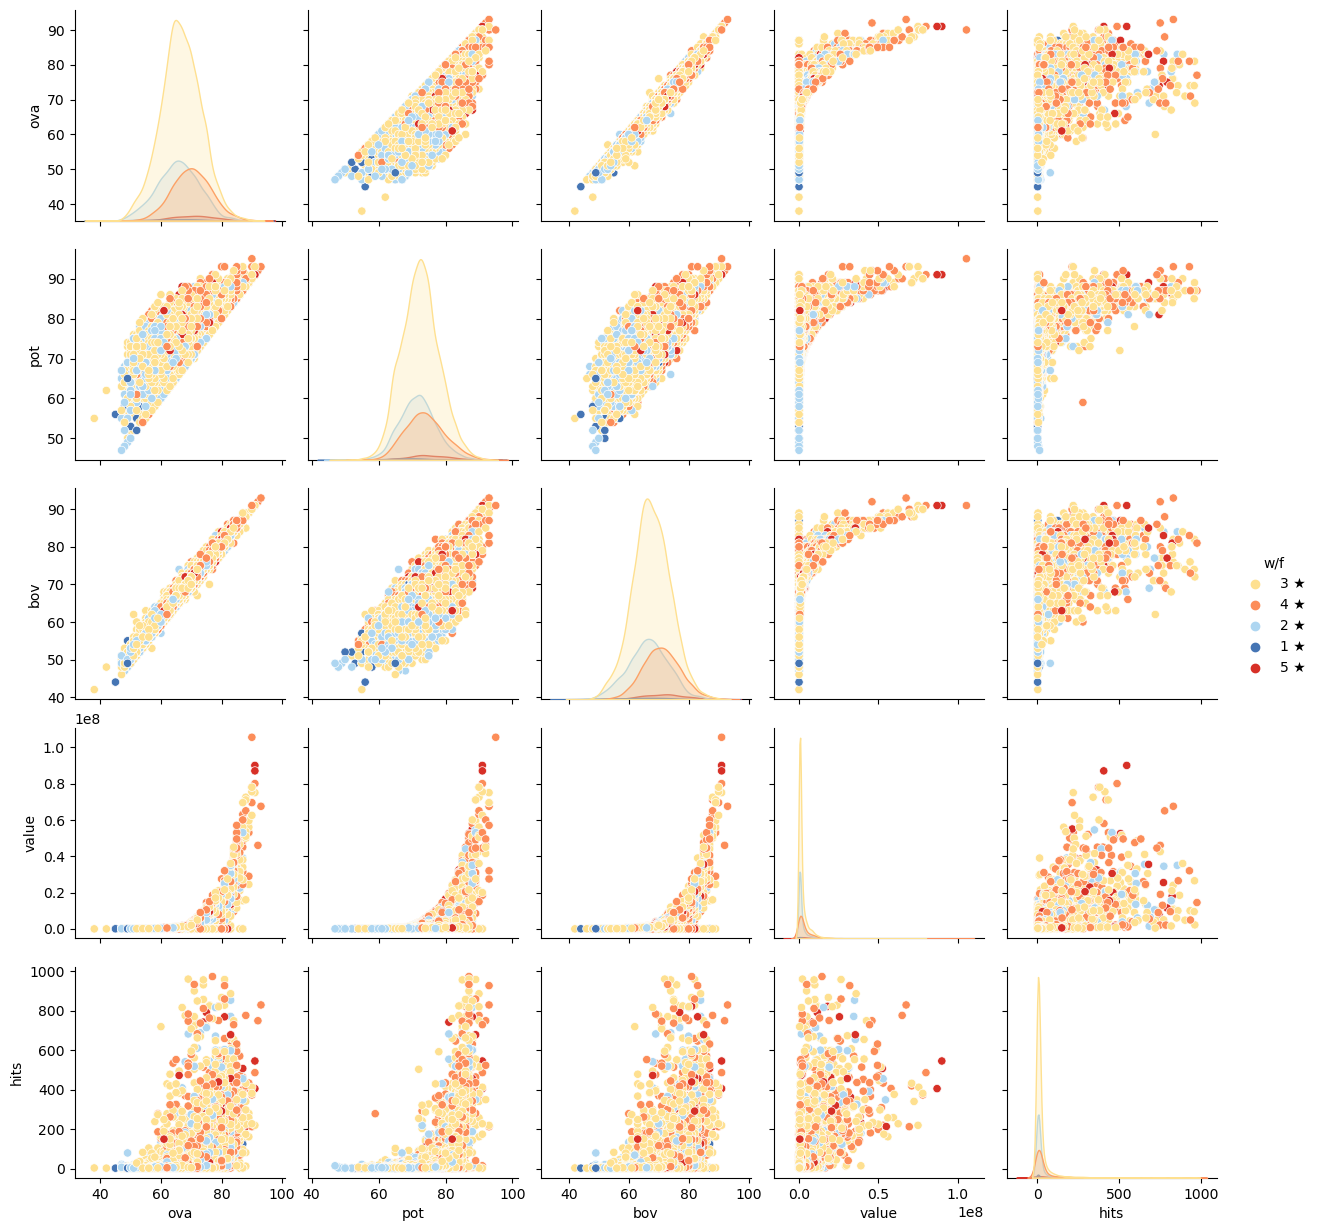

In [12]:
custom_palette = {"1 ★": "#4575B4", "2 ★": "#AED6F1", "3 ★": "#FEE090", "4 ★": "#FC8D59" , "5 ★": "#D73027"}
sns.pairplot(df[['ova', 'pot', 'bov', 'value', 'hits', 'w/f']], hue = 'w/f', palette=custom_palette)
plt.show()

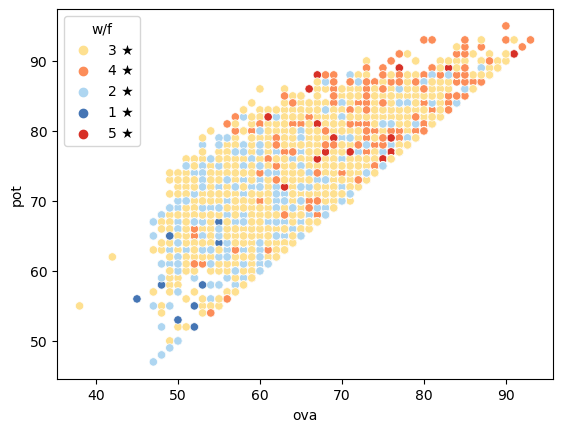

In [13]:
custom_palette = {"1 ★": "#4575B4", "2 ★": "#AED6F1", "3 ★": "#FEE090", "4 ★": "#FC8D59" , "5 ★": "#D73027"}
sns.scatterplot(x = 'ova', y = 'pot', data = df, hue = 'w/f', palette=custom_palette)
plt.show()

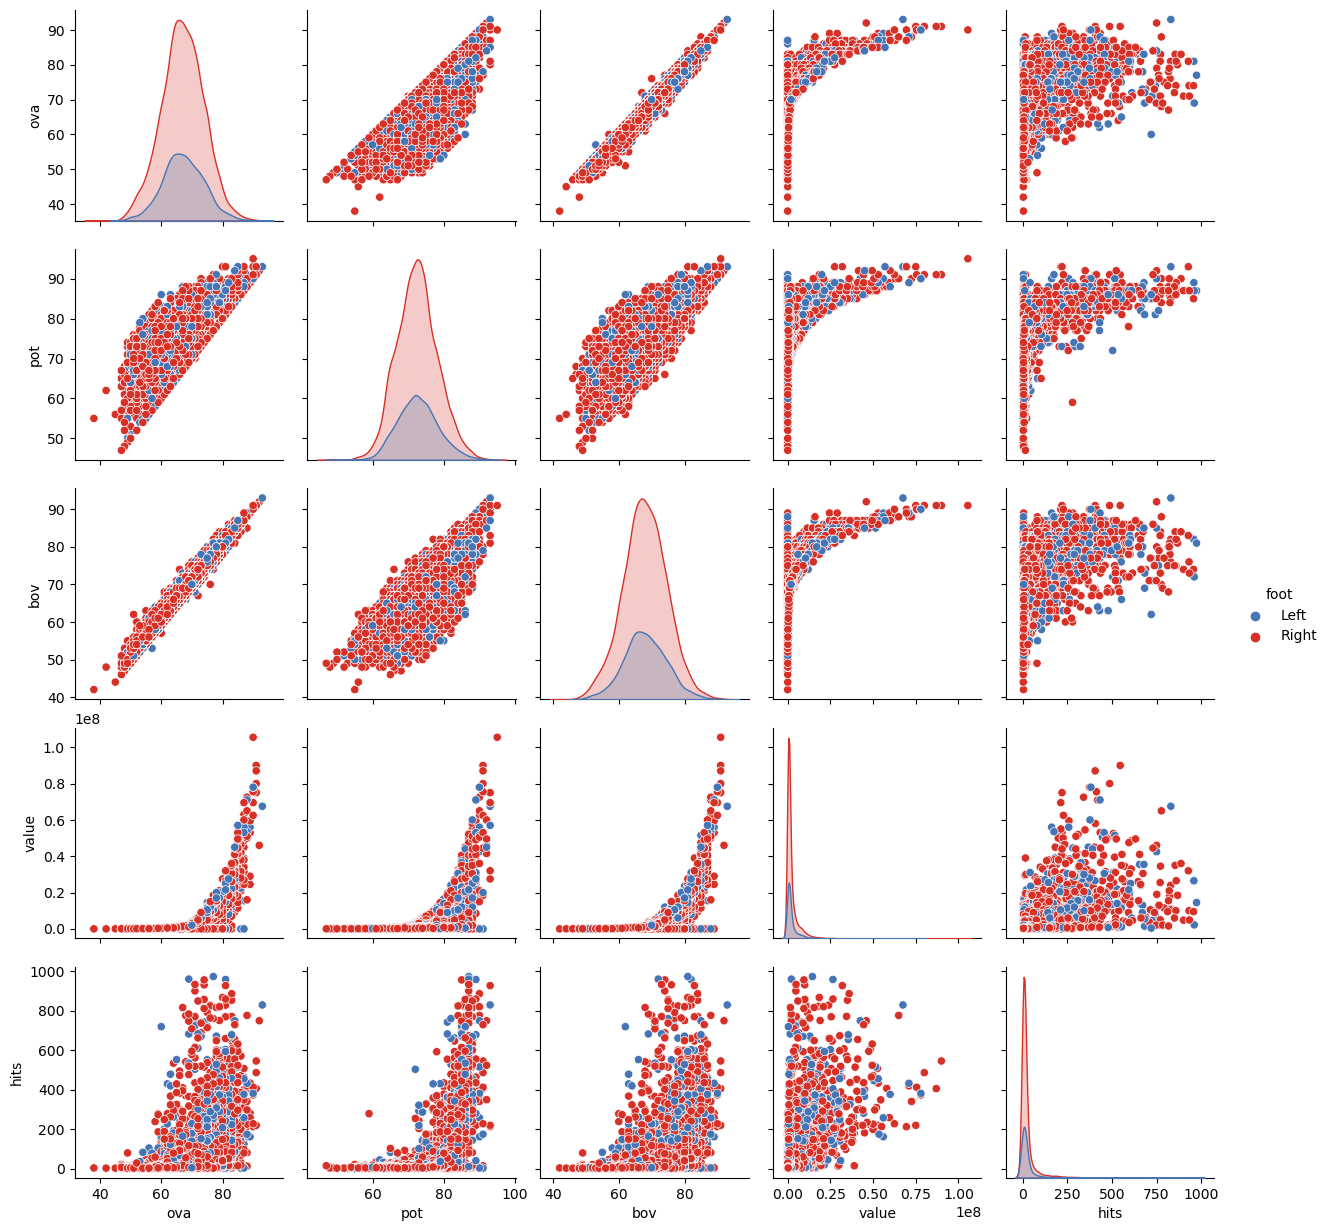

In [14]:
custom_palette = {"Left": "#4575B4", "Right": "#D73027"}
sns.pairplot(df[['ova', 'pot', 'bov', 'value', 'hits', 'foot']], hue = 'foot', palette =custom_palette )
plt.show()

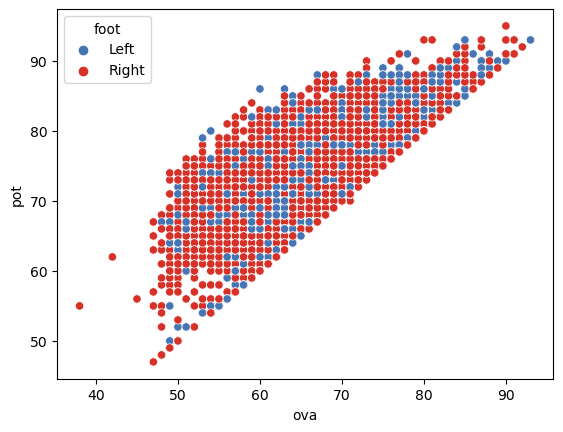

In [15]:
custom_palette = {"Left": "#4575B4", "Right": "#D73027"}
sns.scatterplot(x = 'ova', y = 'pot', data = df, hue = 'foot', palette=custom_palette)
plt.show()

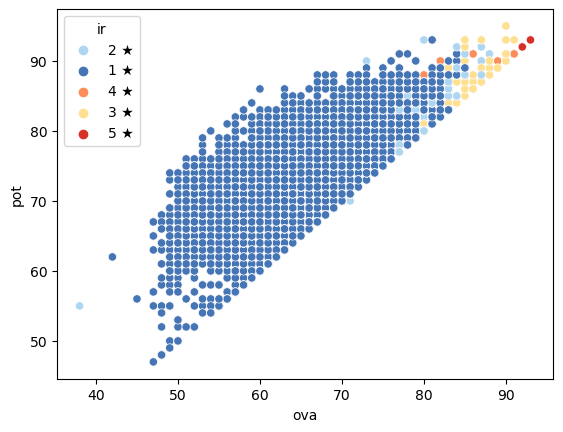

In [16]:
custom_palette = {"1 ★": "#4575B4", "2 ★": "#AED6F1", "3 ★": "#FEE090", "4 ★": "#FC8D59" , "5 ★": "#D73027"}
sns.scatterplot(x = 'ova', y = 'pot', data = df, hue = 'ir', palette=custom_palette)
plt.show()

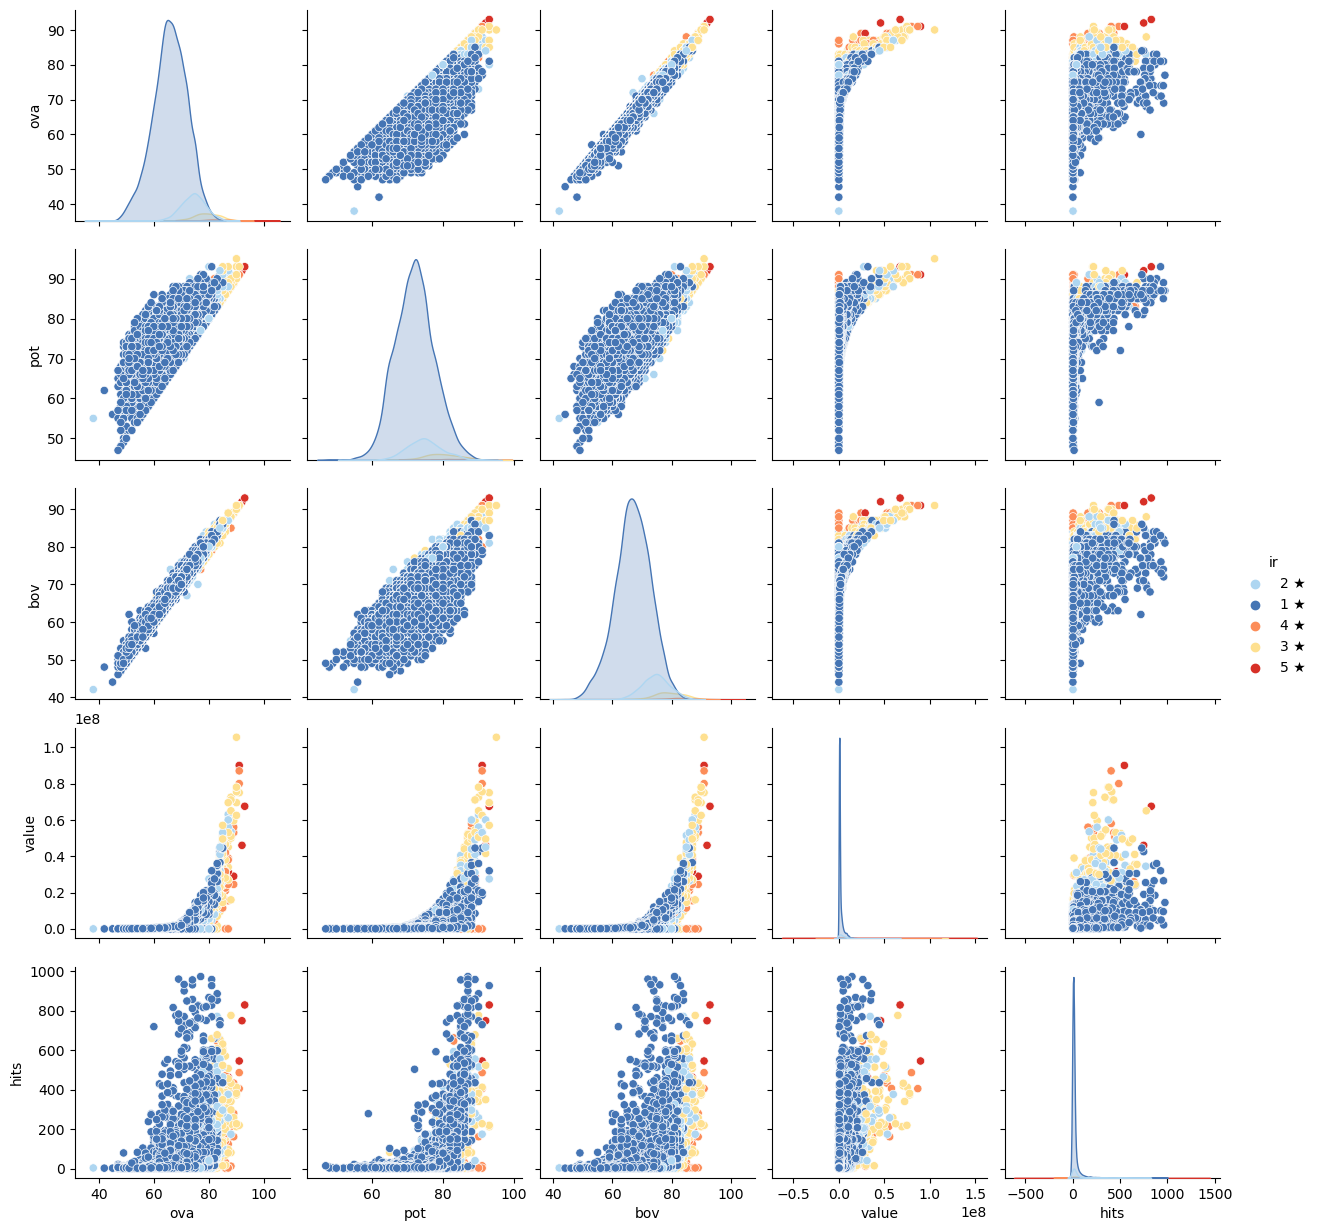

In [17]:
custom_palette = {"1 ★": "#4575B4", "2 ★": "#AED6F1", "3 ★": "#FEE090", "4 ★": "#FC8D59" , "5 ★": "#D73027"}
sns.pairplot(df[['ova', 'pot', 'bov', 'value', 'hits', 'ir']], hue = 'ir', palette =custom_palette )
plt.show()

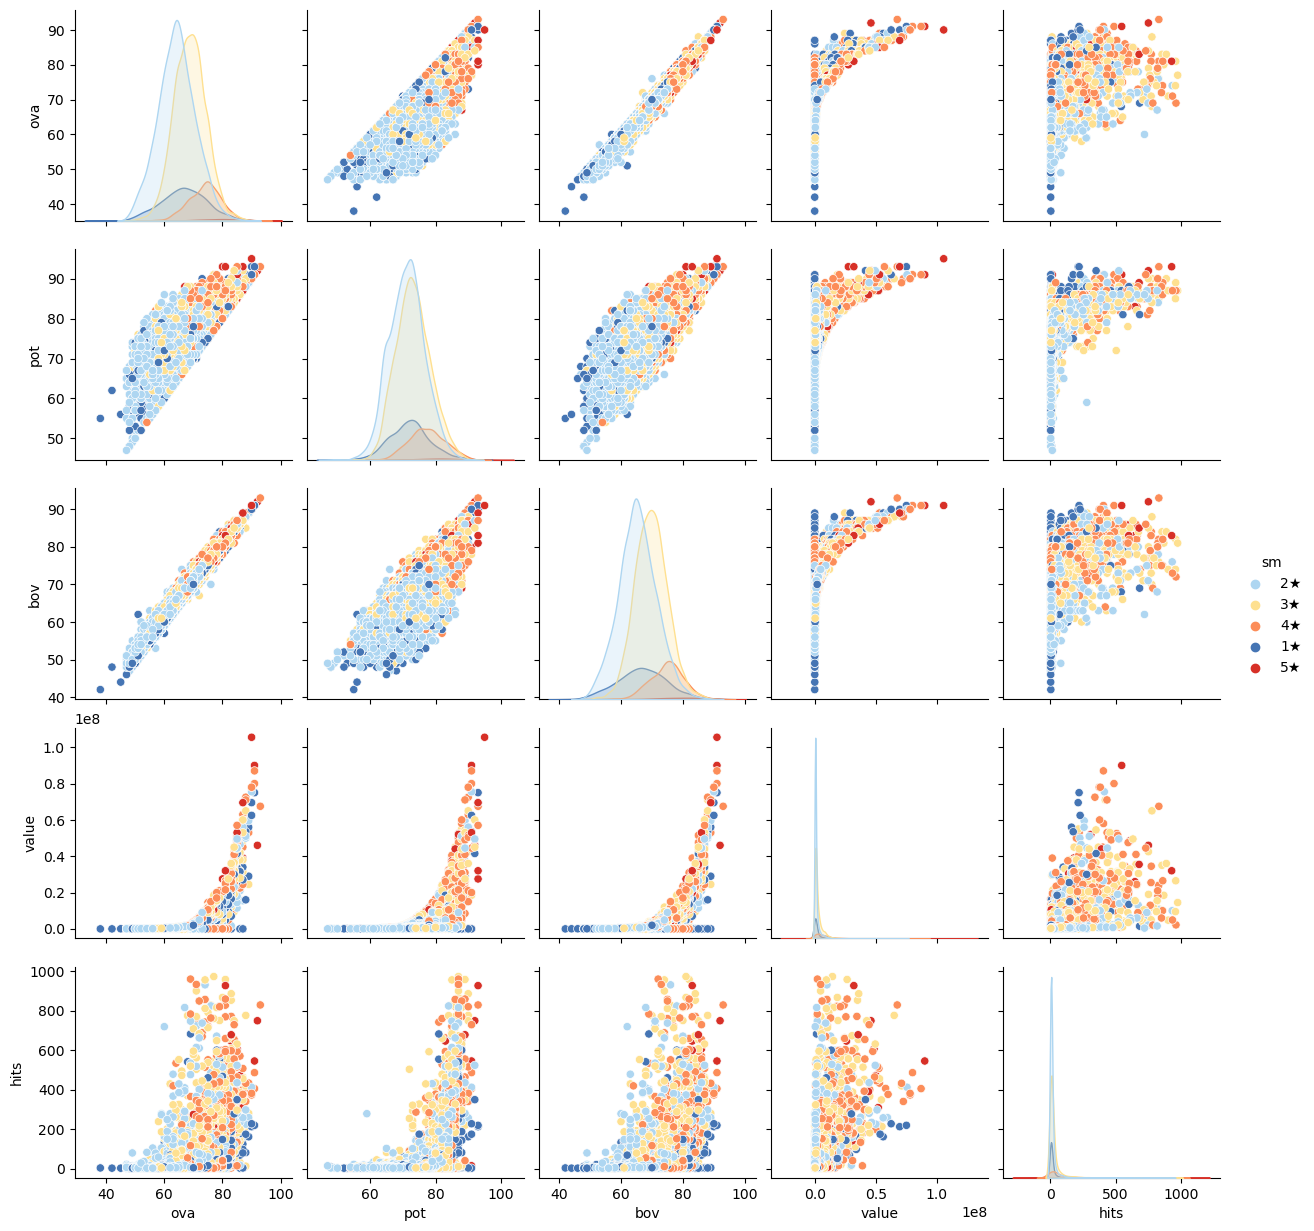

In [18]:
custom_palette = {"1★": "#4575B4", "2★": "#AED6F1", "3★": "#FEE090", "4★": "#FC8D59" , "5★": "#D73027"}
sns.pairplot(df[['ova', 'pot', 'bov', 'value', 'hits', 'sm']], hue = 'sm', palette =custom_palette )
plt.show()

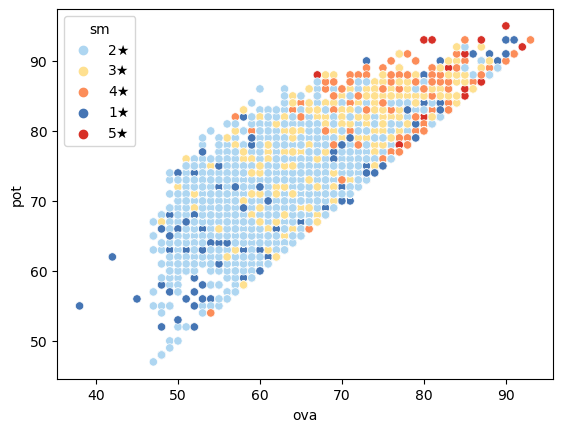

In [19]:
custom_palette = {"1★": "#4575B4", "2★": "#AED6F1", "3★": "#FEE090", "4★": "#FC8D59" , "5★": "#D73027"}
sns.scatterplot(x = 'ova', y = 'pot', data = df, hue = 'sm', palette=custom_palette)
plt.show()

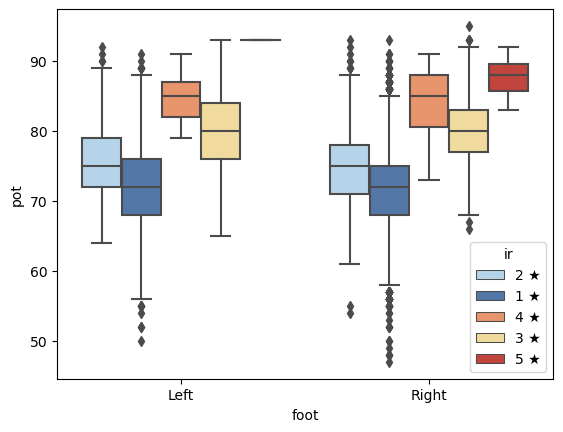

In [20]:
pal = {"1 ★": "#4575B4", "2 ★": "#AED6F1", "3 ★": "#FEE090", "4 ★": "#FC8D59" , "5 ★": "#D73027"}
sns.boxplot(x= 'foot', y = 'pot', data = df, hue = 'ir', palette = pal)
plt.show()

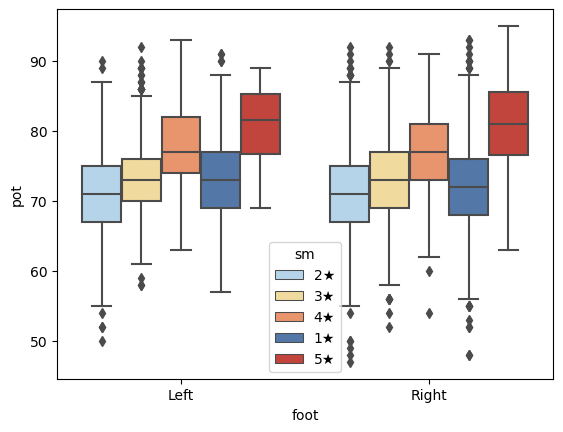

In [21]:
pal = {"1★": "#4575B4", "2★": "#AED6F1", "3★": "#FEE090", "4★": "#FC8D59" , "5★": "#D73027"}
sns.boxplot(x= 'foot', y = 'pot', data = df, hue = 'sm', palette = pal)
plt.show()

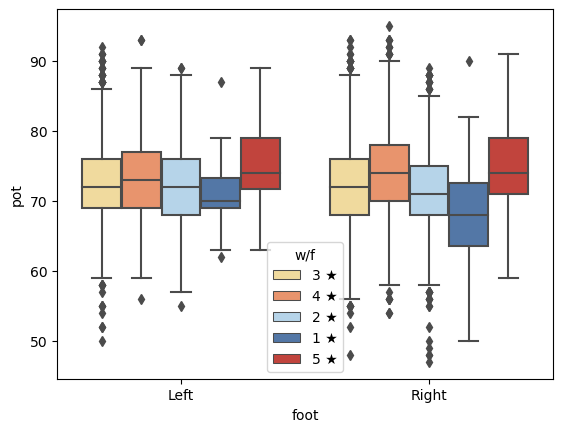

In [22]:
pal = {"1 ★": "#4575B4", "2 ★": "#AED6F1", "3 ★": "#FEE090", "4 ★": "#FC8D59" , "5 ★": "#D73027"}
sns.boxplot(x= 'foot', y = 'pot', data = df, hue = 'w/f', palette = pal)
plt.show()

In [23]:
# Create Correlation matrix to select which columns/attributes have the highest influence in 'potential'
corr_df = df_numeric.corr()
corr_df.head(60)

id       age       ova       bov       pot    growth  \
id                1.000000 -0.743844 -0.431079 -0.385713  0.042604  0.553757   
age              -0.743844  1.000000  0.517099  0.456734 -0.237619 -0.850204   
ova              -0.431079  0.517099  1.000000  0.985877  0.592268 -0.595585   
bov              -0.385713  0.456734  0.985877  1.000000  0.628323 -0.542890   
pot               0.042604 -0.237619  0.592268  0.628323  1.000000  0.294499   
growth            0.553757 -0.850204 -0.595585 -0.542890  0.294499  1.000000   
value            -0.094638  0.095981  0.631679  0.640818  0.563570 -0.187347   
wage             -0.222340  0.200851  0.592925  0.592453  0.462235 -0.242411   
release_clause   -0.068069  0.075386  0.597617  0.608384  0.549201 -0.161274   
attacking        -0.178002  0.183954  0.431238  0.464329  0.233866 -0.278316   
crossing         -0.152858  0.151022  0.386334  0.400046  0.210944 -0.247910   
finishing        -0.110723  0.105311  0.304012  0.336488  0.173281 -0.187820   
heading_accuracy -0.148036  0.172793  0.305553  0.335677  0.137199 -0.225620   
short_passing    -0.173987  0.176786  0.492372  0.533046  0.318544 -0.266404   
volleys          -0.207462  0.187794  0.362712  0.388301  0.177787 -0.252209   
skill            -0.175488  0.168876  0.441689  0.473888  0.265503 -0.259171   
dribbling        -0.061919  0.039607  0.350249  0.388163  0.264651 -0.151568   
curve            -0.200482  0.181021  0.399299  0.419413  0.221502 -0.252074   
fk_accuracy      -0.232269  0.223884  0.369278  0.387289  0.166233 -0.272256   
long_passing     -0.215201  0.223088  0.482655  0.515422  0.283647 -0.289670   
ball_control     -0.134706  0.121097  0.431284  0.471454  0.292414 -0.220001   
movement          0.062316 -0.055642  0.302267  0.335011  0.258243 -0.101046   
acceleration      0.167381 -0.186610  0.143928  0.179547  0.197884  0.026576   
sprint_speed      0.170565 -0.180717  0.153476  0.189491  0.197396  0.014764   
agility           0.019658 -0.041488  0.227253  0.256046  0.190508 -0.079536   
reactions        -0.421033  0.501010  0.870084  0.870157  0.471139 -0.562259   
balance           0.039317 -0.085861  0.100938  0.128361  0.132298  0.011971   
power            -0.224439  0.310459  0.546417  0.572275  0.221586 -0.427168   
shot_power       -0.279340  0.304947  0.534829  0.550932  0.266902 -0.368246   
jumping          -0.145467  0.197371  0.259915  0.264297  0.076414 -0.231306   
stamina           0.014947  0.069741  0.335108  0.368788  0.170122 -0.227850   
strength         -0.246480  0.350439  0.338347  0.335436  0.030991 -0.370401   
long_shots       -0.185208  0.190803  0.390849  0.419660  0.191780 -0.272371   
mentality        -0.246674  0.272976  0.495097  0.523526  0.243646 -0.344307   
aggression       -0.223598  0.276063  0.382813  0.400031  0.139444 -0.315017   
interceptions    -0.157559  0.192996  0.305286  0.320034  0.143810 -0.218619   
positioning      -0.127911  0.122566  0.339838  0.368287  0.191976 -0.211575   
vision           -0.247664  0.236343  0.507683  0.530160  0.306404 -0.295917   
penalties        -0.218133  0.198917  0.317666  0.340311  0.147044 -0.230172   
composure        -0.423060  0.421126  0.706141  0.721989  0.369826 -0.466145   
defending        -0.070775  0.114796  0.248247  0.267770  0.138748 -0.156108   
marking          -0.106629  0.155497  0.290071  0.309674  0.147320 -0.197168   
standing_tackle  -0.073895  0.106178  0.237478  0.257583  0.138787 -0.143297   
sliding_tackle   -0.056243  0.086021  0.209961  0.228406  0.129735 -0.119390   
goalkeeping      -0.095273  0.125933  0.038222 -0.008702 -0.007277 -0.052589   
gk_diving        -0.089003  0.120891  0.037851 -0.008851 -0.005874 -0.050750   
gk_handling      -0.100717  0.125251  0.037993 -0.008312 -0.005240 -0.050286   
gk_kicking       -0.122380  0.130810  0.038650 -0.006124 -0.002734 -0.048566   
gk_positioning   -0.106509  0.134369  0.044653 -0.000933 -0.004015 -0.056963   
gk_reflexes      -0.0947

In [24]:
# Filter correlation matrix so we only keep correlation values greater than ABS(0.5) (Moderate correlation)

corr_df_filtered = corr_df[corr_df['pot'] >= abs(0.5)]
corr_df_filtered.head(500)

id       age       ova       bov       pot    growth  \
ova            -0.431079  0.517099  1.000000  0.985877  0.592268 -0.595585   
bov            -0.385713  0.456734  0.985877  1.000000  0.628323 -0.542890   
pot             0.042604 -0.237619  0.592268  0.628323  1.000000  0.294499   
value          -0.094638  0.095981  0.631679  0.640818  0.563570 -0.187347   
release_clause -0.068069  0.075386  0.597617  0.608384  0.549201 -0.161274   
hits            0.032869 -0.097518  0.374210  0.399528  0.520248  0.070853   

                   value      wage  release_clause  attacking  ...  \
ova             0.631679  0.592925        0.597617   0.431238  ...   
bov             0.640818  0.592453        0.608384   0.464329  ...   
pot             0.563570  0.462235        0.549201   0.233866  ...   
value           1.000000  0.822728        0.979295   0.289886  ...   
release_clause  0.979295  0.798432        1.000000   0.269036  ...   
hits            0.616474  0.500832        0.620867   0.191418  ...   

                gk_reflexes  total_stats  base_stats       pac       sho  \
ova                0.037284     0.607676    0.832618  0.201319  0.487060   
bov               -0.008819     0.635037    0.830127  0.212889  0.478573   
pot               -0.005215     0.329178    0.474763  0.259294  0.244481   
value              0.002476     0.393043    0.526843  0.210809  0.323770   
release_clause     0.004309     0.368406    0.497094  0.200583  0.300981   
hits              -0.035187     0.248055    0.314533  0.188020  0.173052   

                     pas       dri       def       phy      hits  
ova             0.699229  0.643427  0.344906  0.543354  0.374210  
bov             0.689975  0.640746  0.349906  0.535579  0.399528  
pot             0.395773  0.445004  0.170562  0.159959  0.520248  
value           0.444484  0.442156  0.172856  0.266541  0.616474  
release_clause  0.418093  0.416343  0.167362  0.250809  0.620867  
hits            0.253134  0.288750  0.093164  0.120371  1.000000  

[6 rows x 59 columns]

In [25]:
# Filter original data frame so we only keep columns with the highest correlation

df_numeric_filtered = df[['ova', 'bov', 'pot', 'value', 'release_clause', 'hits']]
df_numeric_filtered.head()

ova  bov  pot      value  release_clause   hits
0   69   71   69   625000.0             0.0    4.0
1   71   70   71   600000.0       1100000.0    4.0
2   71   71   71  1100000.0             0.0   11.0
3   68   70   82        0.0             0.0    3.0
4   81   82   81  5500000.0       7200000.0  149.0

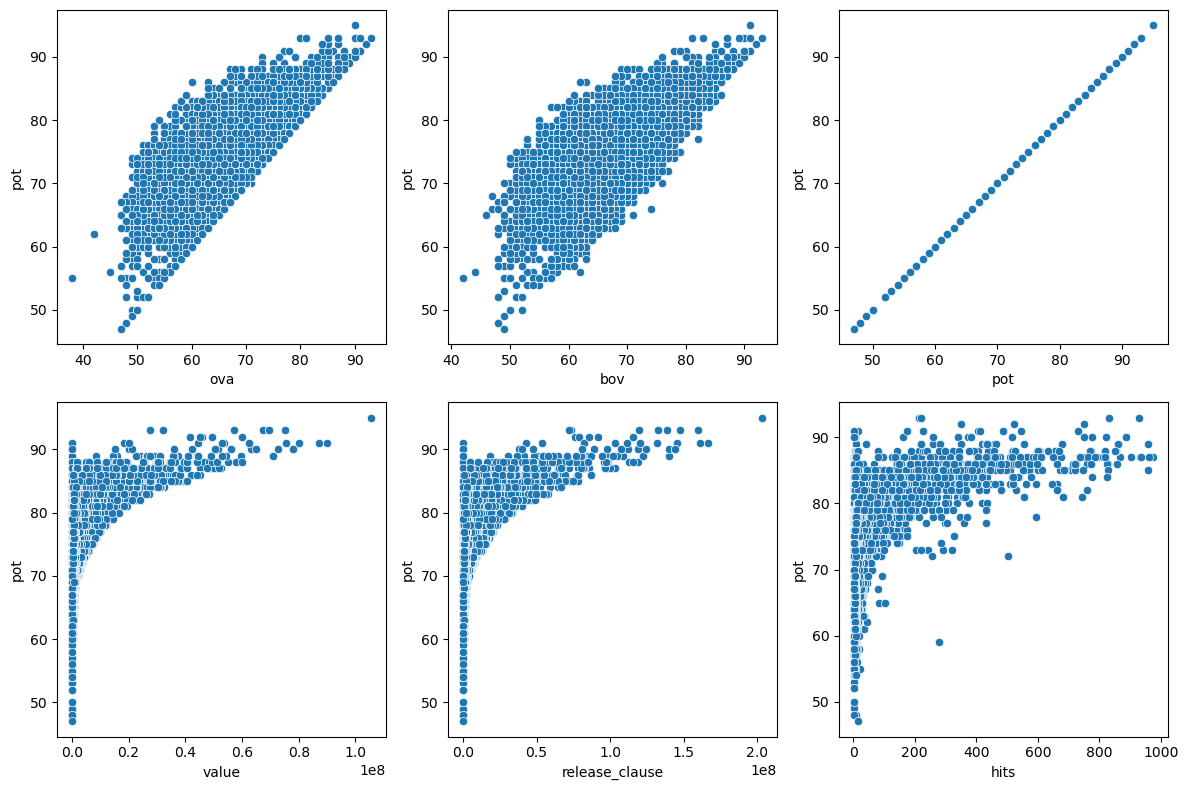

In [26]:
# Create scatter plots of the selected independent variables with respect to 'potential'
plot_scatter(df_numeric_filtered)

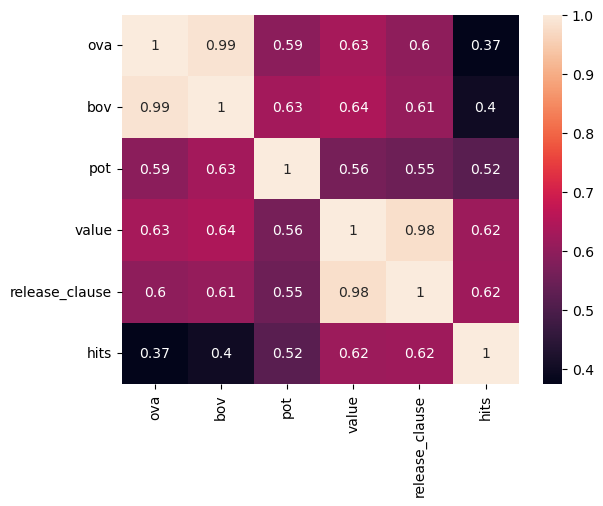

In [27]:
sns.heatmap(df_numeric_filtered.corr(), annot=True)
plt.show()

In [28]:
check_nan_values(df_numeric_filtered)
df_numeric_filtered['hits'] = df_numeric_filtered['hits'].fillna(0)
check_nan_values(df_numeric_filtered)

The percentage of NaN values per column is:
 ova               0.000000
bov               0.000000
pot               0.000000
value             0.000000
release_clause    0.000000
hits              0.373723
dtype: float64
The percentage of NaN values per column is:
 ova               0.0
bov               0.0
pot               0.0
value             0.0
release_clause    0.0
hits              0.0
dtype: float64


C:\Users\pgarciag\AppData\Local\Temp\ipykernel_2508\1258302235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric_filtered['hits'] = df_numeric_filtered['hits'].fillna(0)


In [29]:
# Drop numeric values that are highly correlated with each other:

df_num_1 = df_numeric_filtered.drop(['release_clause','bov'], axis =1) # Keep only OVA, Value and Hits
df_num_2 = df_numeric_filtered.drop(['release_clause','bov', 'hits'], axis =1) # Only OVA and Value
df_num_3 = df_numeric_filtered.drop(['release_clause','ova', 'hits'], axis =1) # Only BOV and Value
df_num_4 = df_numeric_filtered.drop(['release_clause','ova'], axis =1) # Only BOV, Value and Hits

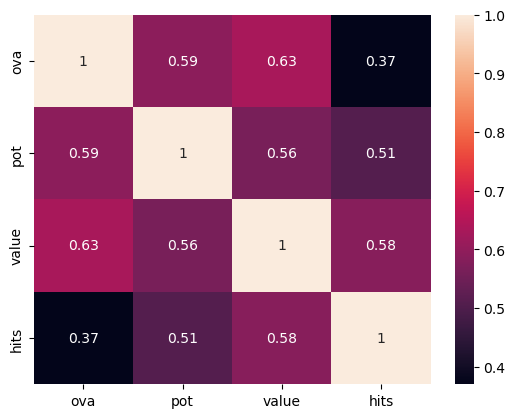

In [30]:
sns.heatmap(df_num_1.corr(), annot=True)
plt.show()

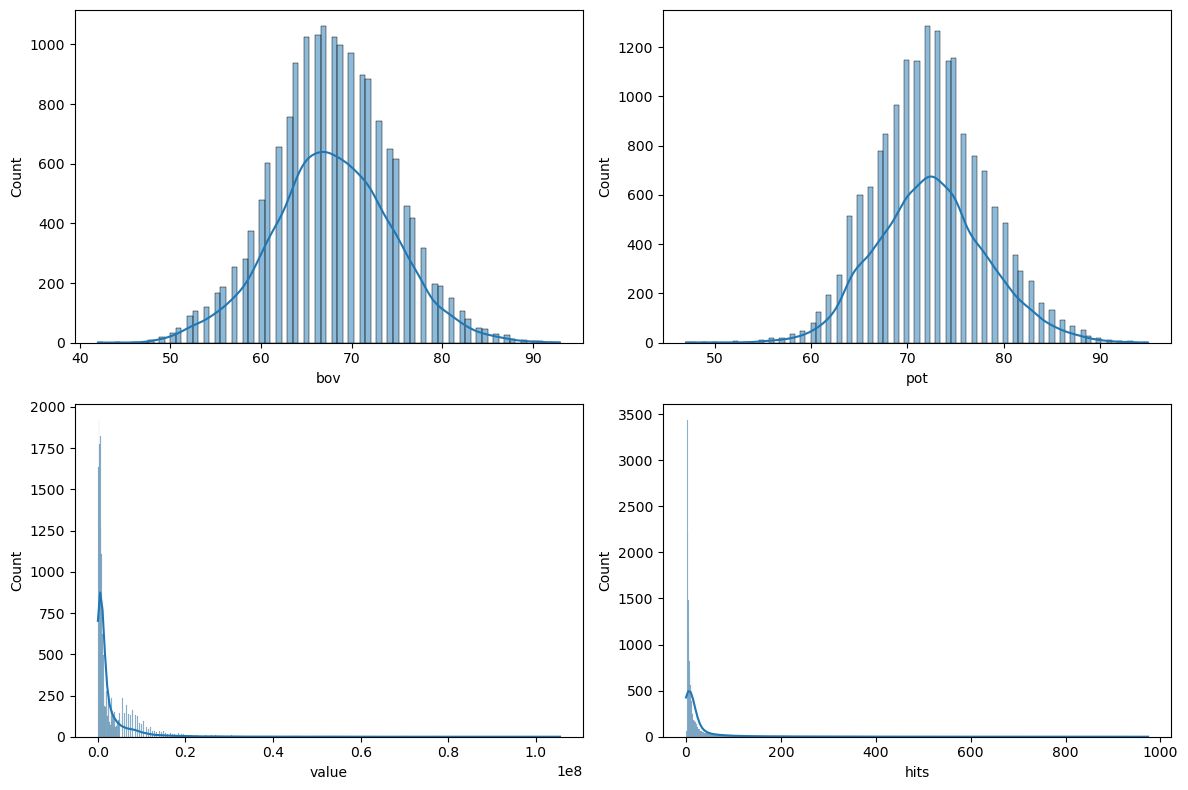

In [31]:
plot_hist(df_num_4)

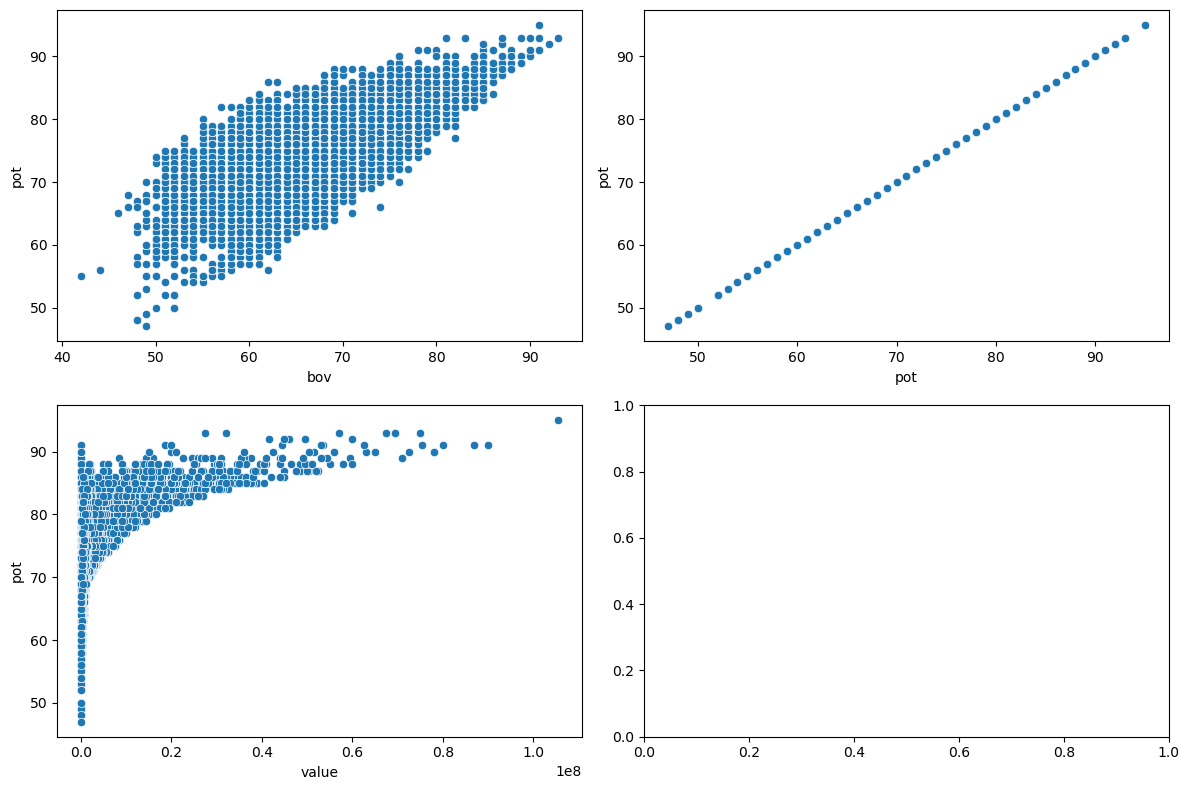

In [32]:
plot_scatter(df_num_3)

In [33]:
# Split Dependent and Independent variables
x_num_1, y = split_numerical(df_num_1, 'pot')
x_num_2, y = split_numerical(df_num_2, 'pot')
x_num_3, y = split_numerical(df_num_3, 'pot')
x_num_4, y = split_numerical(df_num_4, 'pot')

In [34]:
x_num_4

bov      value   hits
0       71   625000.0    4.0
1       70   600000.0    4.0
2       71  1100000.0   11.0
3       70        0.0    3.0
4       82  5500000.0  149.0
...    ...        ...    ...
17120   66   550000.0    5.0
17121   58   130000.0    5.0
17122   56   130000.0    3.0
17123   62   475000.0    5.0
17124   61   325000.0    4.0

[17125 rows x 3 columns]

In [35]:
y

0        69
1        71
2        71
3        82
4        81
         ..
17120    69
17121    66
17122    67
17123    73
17124    74
Name: pot, Length: 17125, dtype: int64

In [36]:
x_log_1 = log_transformer(x_num_1, ['value','hits'])
x_log_2 = log_transformer(x_num_2, ['value'])
x_log_3 = log_transformer(x_num_3, ['value'])
x_log_4 = log_transformer(x_num_4, ['value','hits'])

C:\Users\pgarciag\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


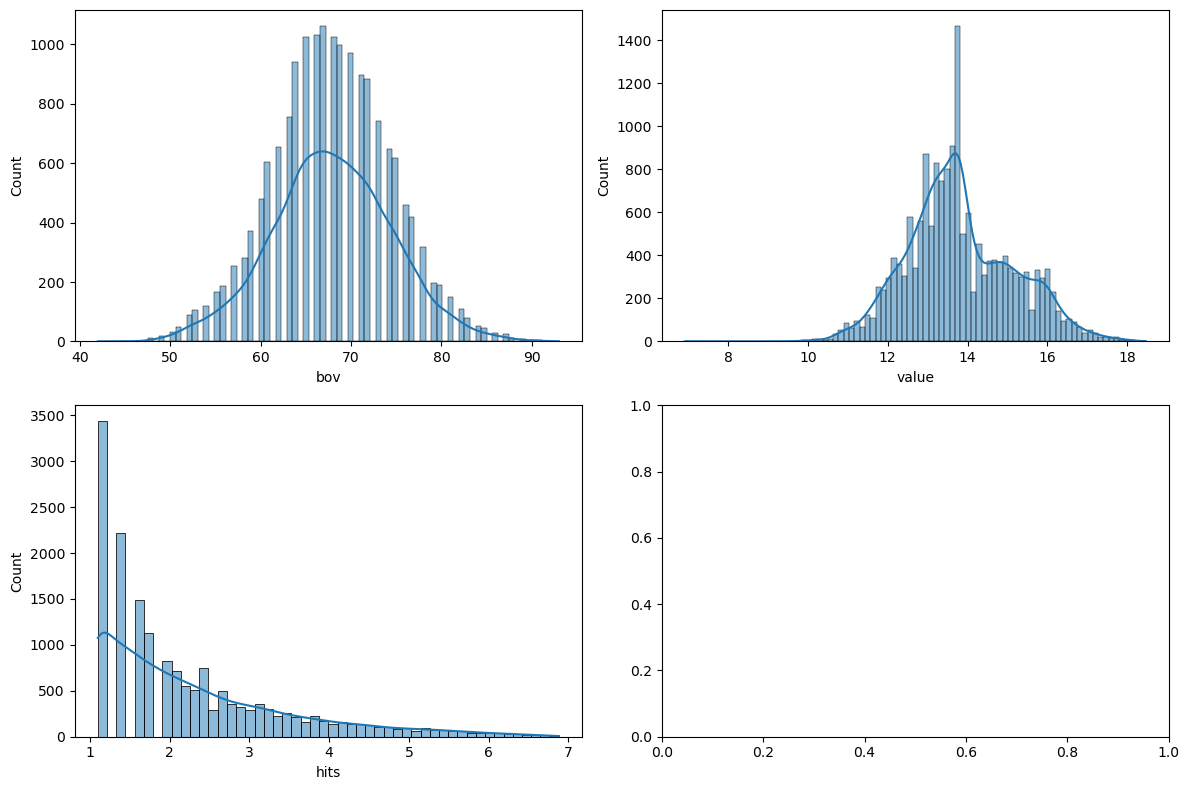

In [37]:
plot_hist(x_log_4)

In [38]:
x_cox_1 = box_cox_transformer(x_num_1, ['value','hits'])
x_cox_2 = box_cox_transformer(x_num_2, ['value'])
x_cox_3 = box_cox_transformer(x_num_3, ['value'])
x_cox_4 = box_cox_transformer(x_num_4, ['value','hits'])

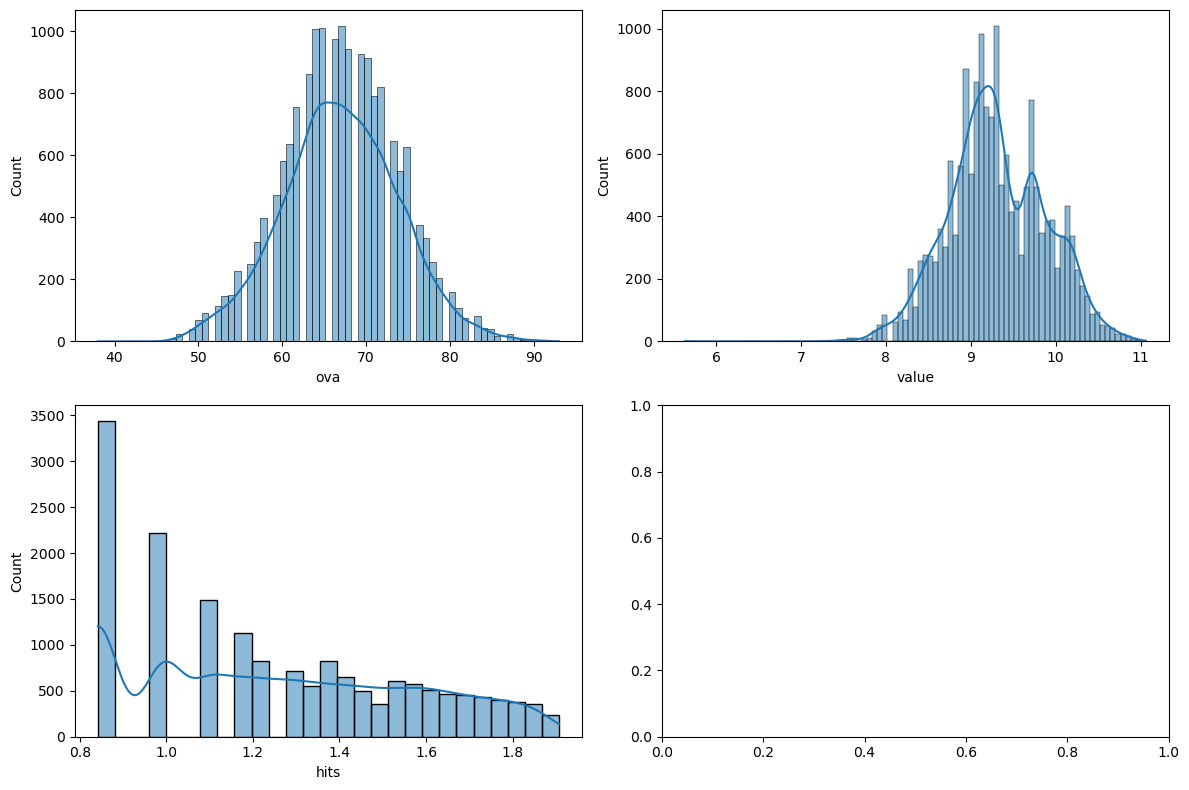

In [39]:
plot_hist(x_cox_1)

In [40]:
# Standarization using MinMax Scaler and Standard Scaler
x_log_minmax_1 =  min_max_scaler(x_log_1)
x_log_minmax_2 =  min_max_scaler(x_log_2)
x_log_minmax_3 =  min_max_scaler(x_log_3)
x_log_minmax_4 =  min_max_scaler(x_log_4)

x_log_std_1 = standard_scaler(x_log_1)
x_log_std_2 = standard_scaler(x_log_2)
x_log_std_3 = standard_scaler(x_log_3)
x_log_std_4 = standard_scaler(x_log_4)

x_cox_minmax_1 =  min_max_scaler(x_cox_1)
x_cox_minmax_2 =  min_max_scaler(x_cox_2)
x_cox_minmax_3 =  min_max_scaler(x_cox_3)
x_cox_minmax_4 =  min_max_scaler(x_cox_4)

x_cox_std_1 = standard_scaler(x_cox_1)
x_cox_std_2 = standard_scaler(x_cox_2)
x_cox_std_3 = standard_scaler(x_cox_3)
x_cox_std_4 = standard_scaler(x_cox_4)

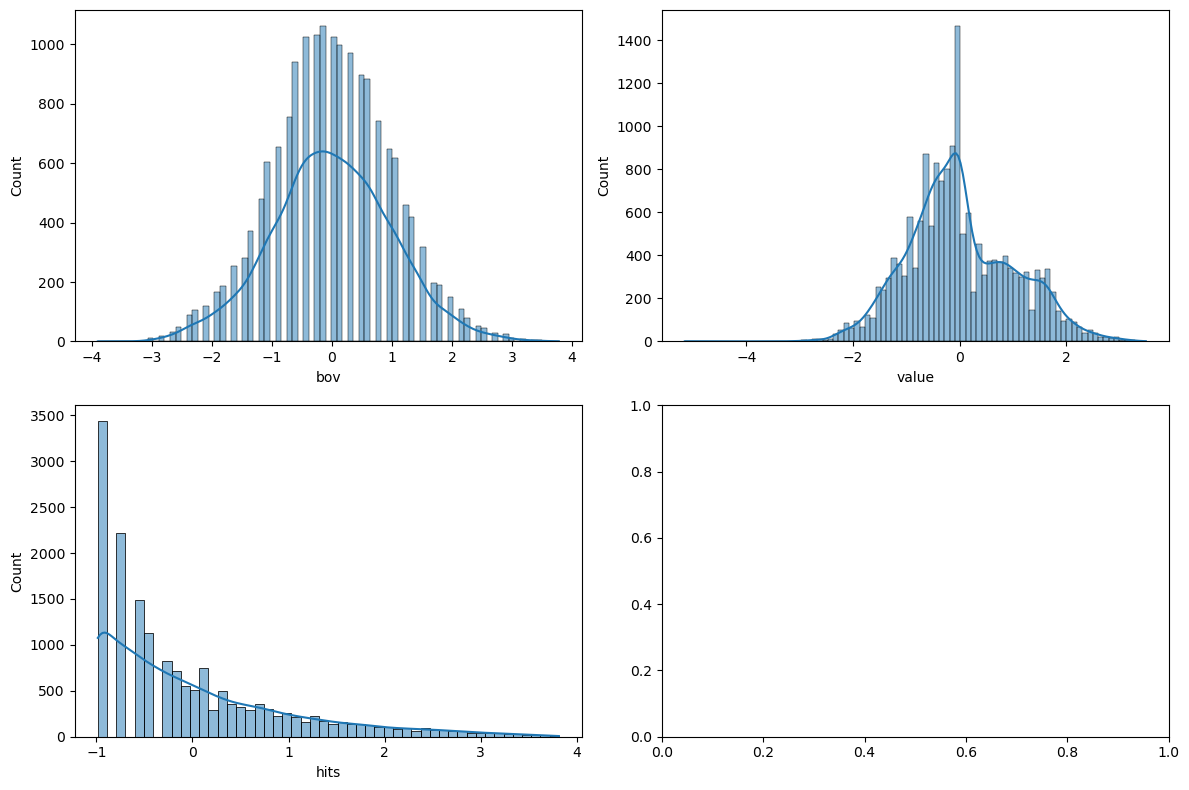

In [41]:
plot_hist(x_log_std_4)

In [42]:
x_log_std_3.shape

(17125, 2)

In [43]:
y.shape

(17125,)

In [44]:
# Categorical data workflow 
df_categorical_name = df_categorical['name']
df_categorical.columns

Index(['name', 'nationality', 'club', 'bp', 'position', 'player_photo',
       'club_logo', 'flag_photo', 'team_&_contract', 'height', 'weight',
       'foot', 'joined', 'loan_date_end', 'contract', 'w/f', 'sm', 'a/w',
       'd/w', 'ir', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam',
       'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm',
       'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk', 'gender'],
      dtype='object')

In [45]:
# Filter df_categorical data to only keep the ones we think will have higher correlation with 'potencial'
# df_categorical_filtered = df.loc[:, ['w/f', 'sm', 'ir']]
# df_categorical_filtered.head(100)

In [46]:
# columns to use from categorical data ['position', 'foot', 'w/f', 'sm', 'a/w','d/w', 'ir'])
    # Categoric: SM, W/F, Foot.

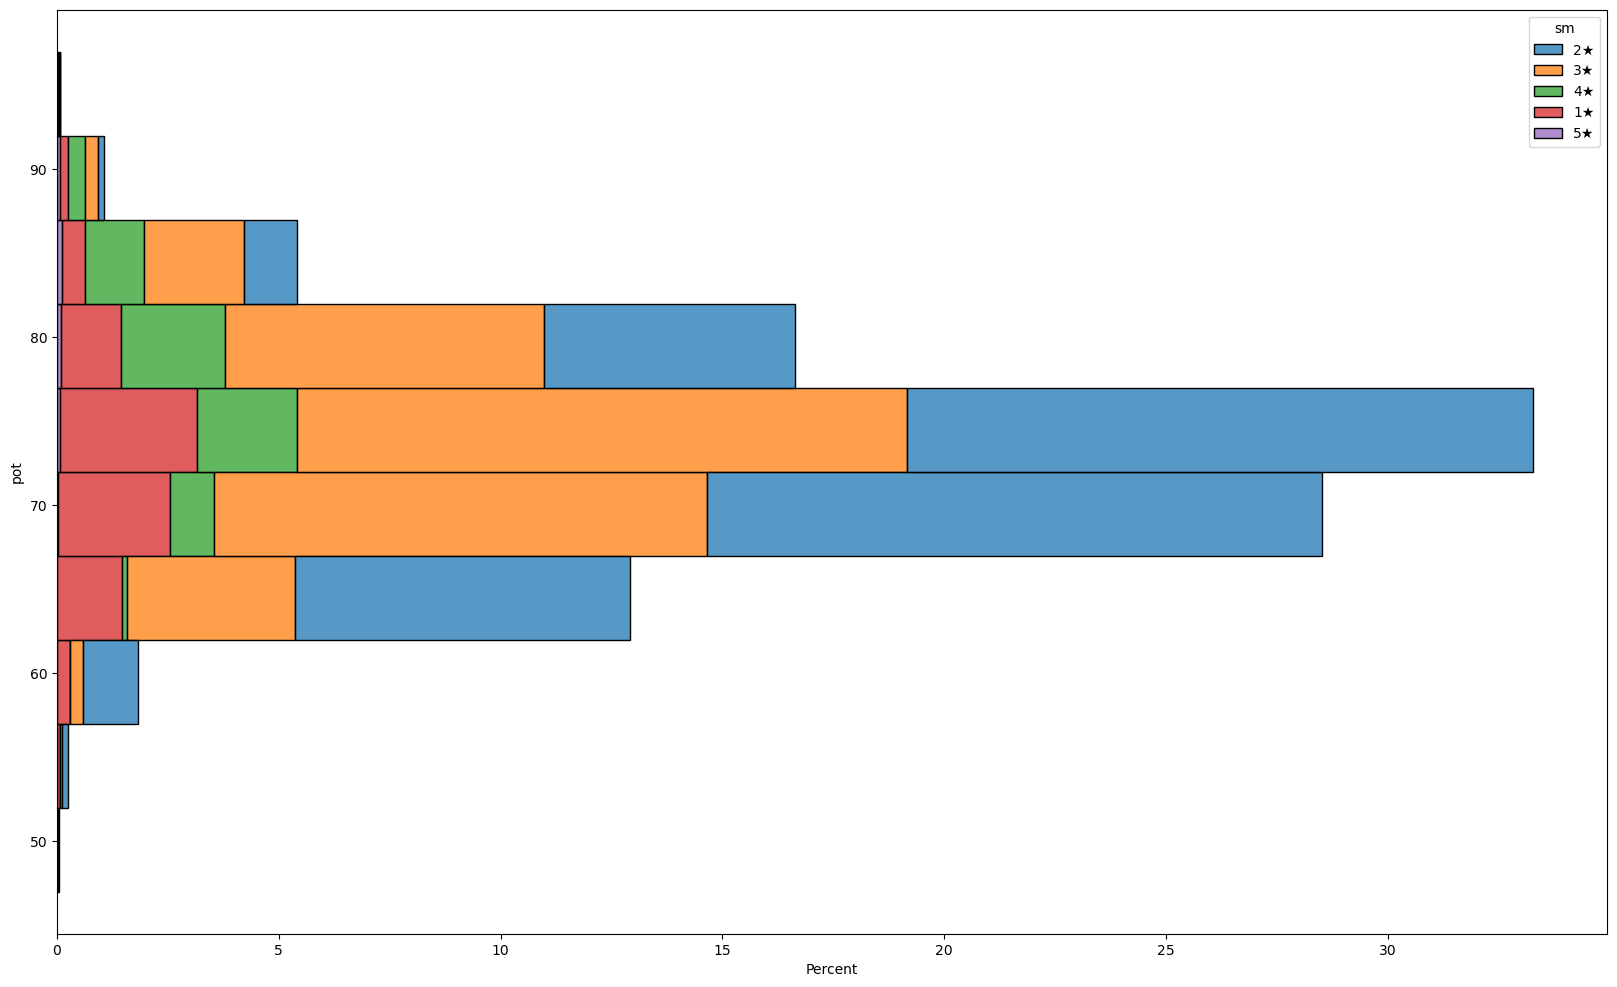

In [47]:
# SKILL MOVES HIST PLOT
plt.figure(figsize=(20,12))
ax = sns.histplot(data=df, y='pot', hue='sm', stat='percent', multiple='stack', binwidth=5)
# ax.legend()
plt.show()

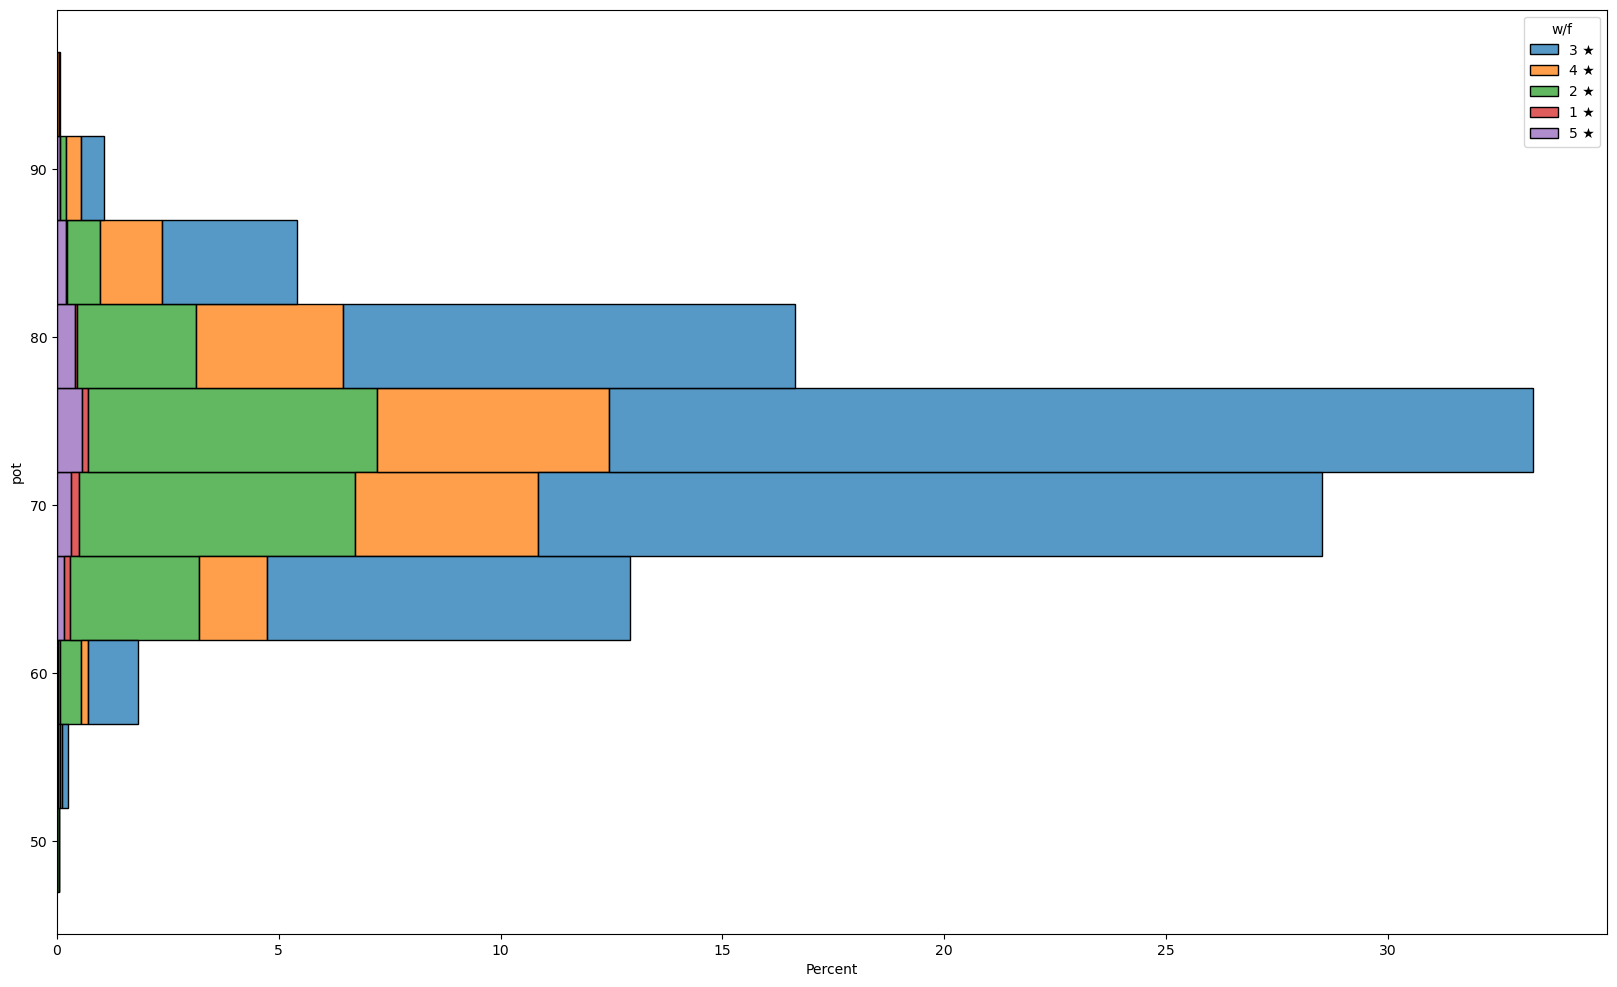

In [48]:
# WEAK FOOT HIST PLOT
plt.figure(figsize=(20,12))
sns.histplot(data=df, y='pot', hue='w/f', stat='percent', multiple='stack', binwidth=5)
plt.show()

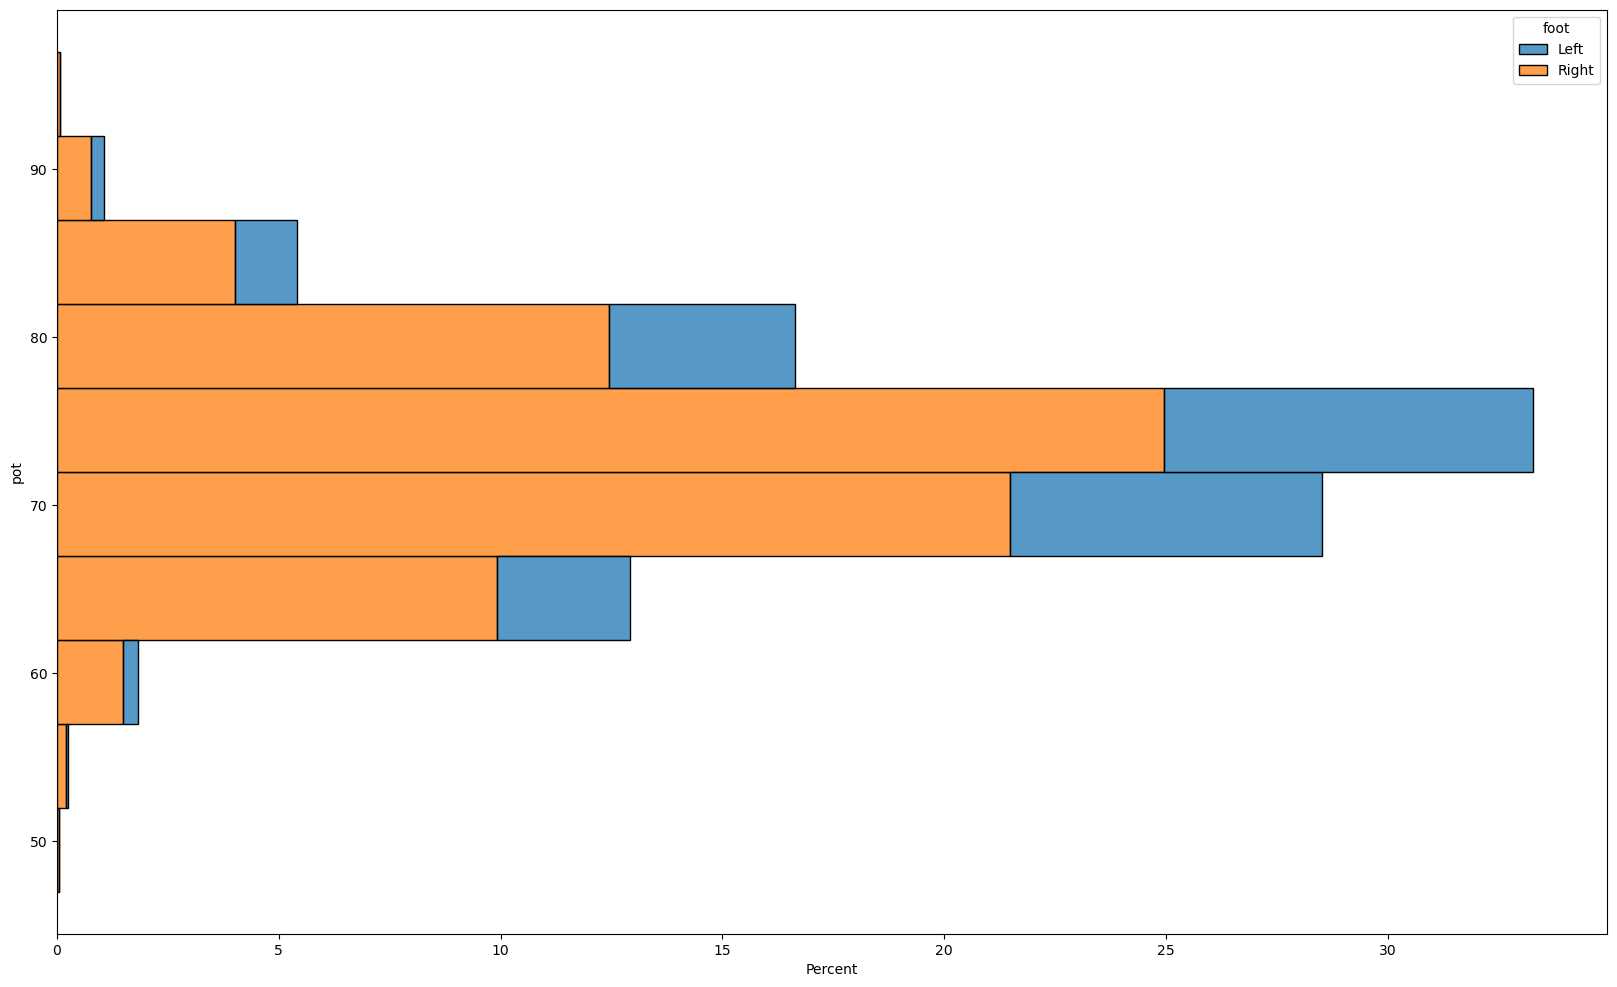

In [49]:
# FOOT HIST PLOT
plt.figure(figsize=(20,12))
sns.histplot(data=df, y='pot', hue='foot', stat='percent', multiple='stack', binwidth=5)
plt.show()

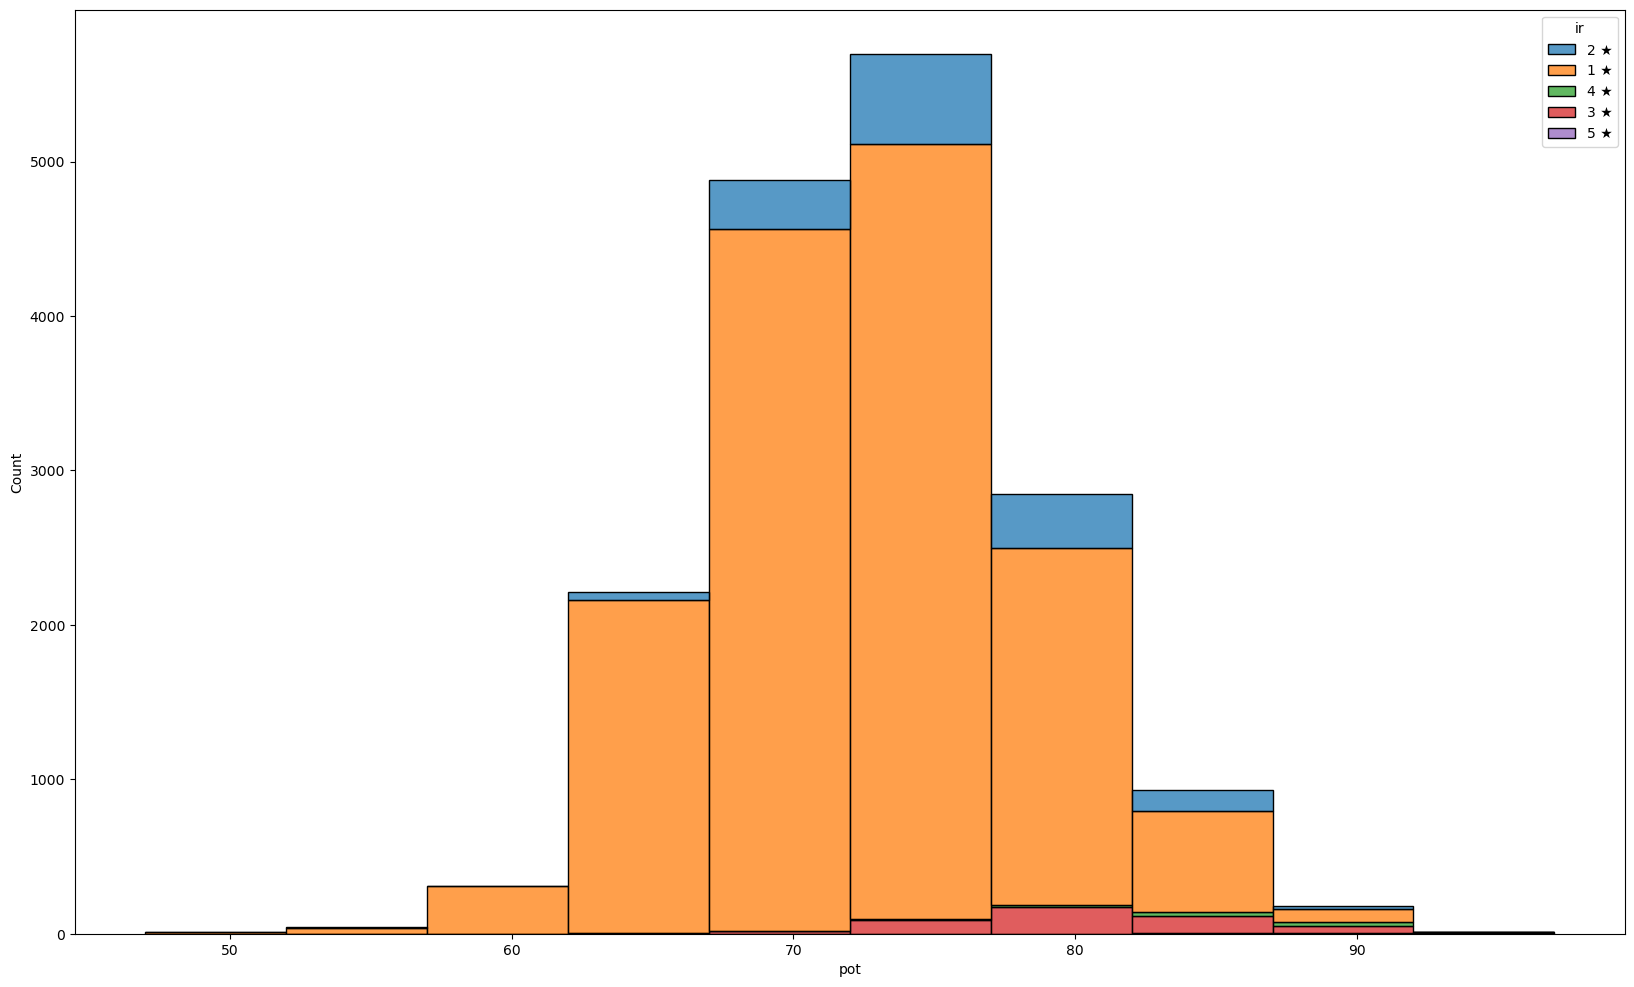

In [50]:
plt.figure(figsize=(20,12))
sns.histplot(data=df, x='pot', hue='ir', stat='count', multiple='stack', binwidth=5)
plt.show()

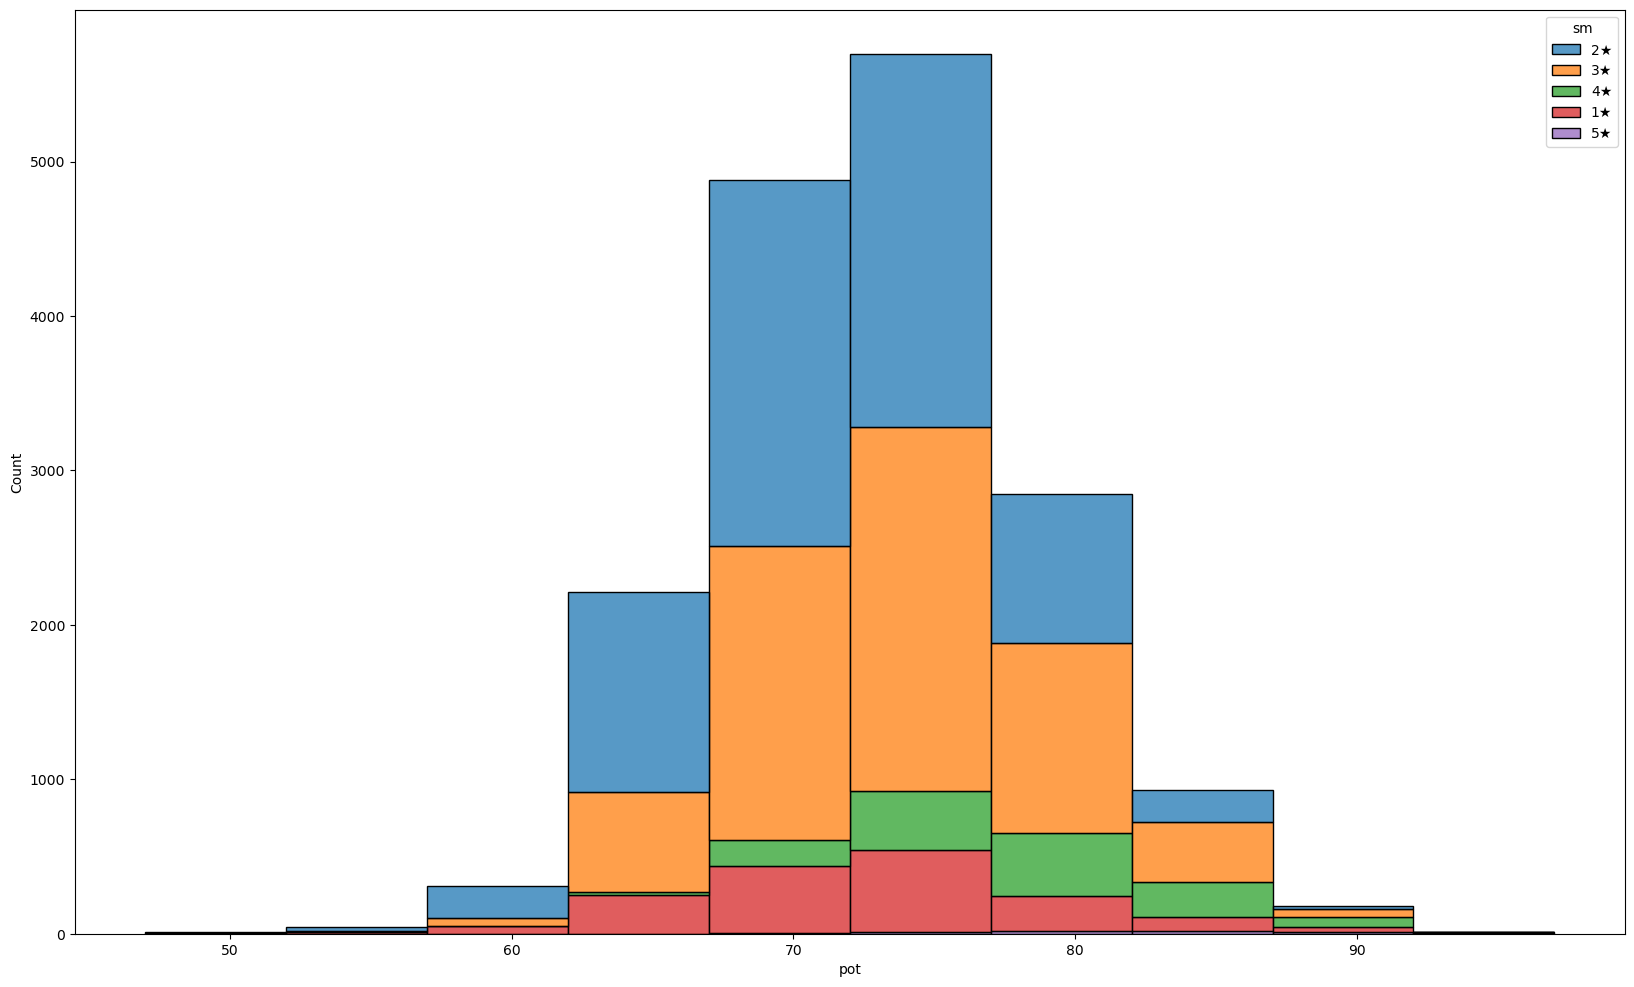

In [51]:
plt.figure(figsize=(20,12))
sns.histplot(data=df, x='pot', hue='sm', stat='count', multiple='stack', binwidth=5)
plt.show()

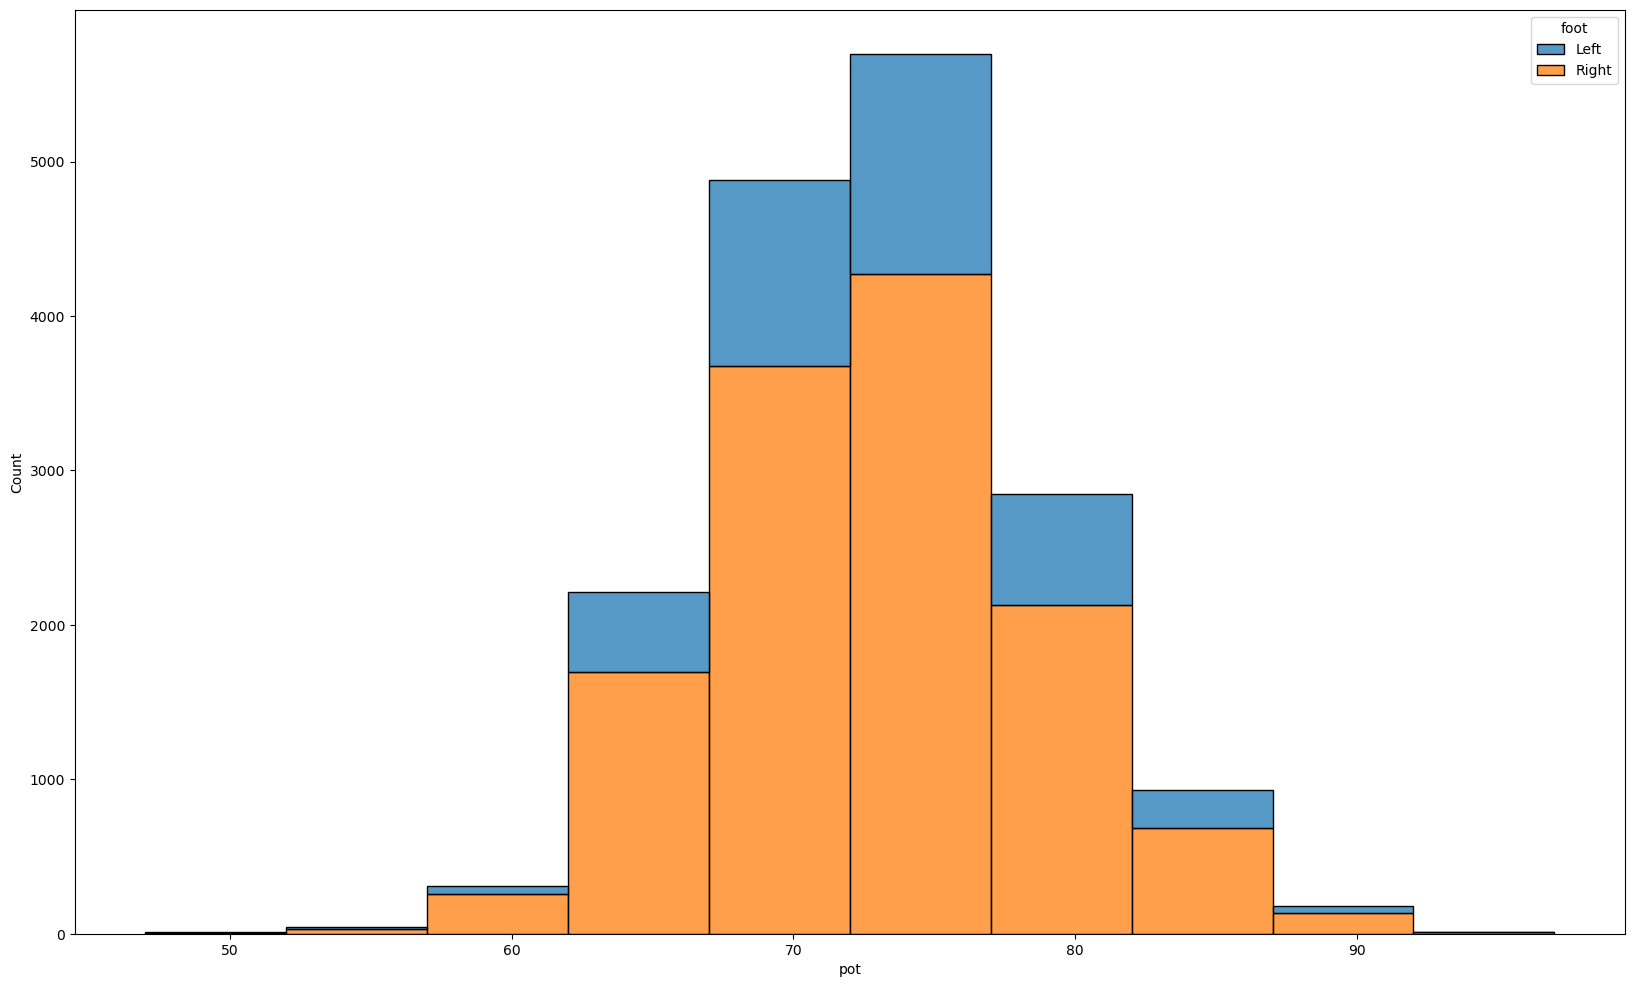

In [52]:
plt.figure(figsize=(20,12))
sns.histplot(data=df, x='pot', hue='foot', stat='count', multiple='stack', binwidth=5)
plt.show()

In [53]:
x_cat_1 = df_categorical[['foot', 'ir', 'w/f']]
x_cat_1 = one_hot_encoder(x_cat_1, ['foot', 'ir', 'w/f'])    
x_cat_1.head()

foot_Left  foot_Right  ir_1 ★  ir_2 ★  ir_3 ★  ir_4 ★  ir_5 ★  w/f_1 ★  \
0        1.0         0.0     0.0     1.0     0.0     0.0     0.0      0.0   
1        0.0         1.0     1.0     0.0     0.0     0.0     0.0      0.0   
2        0.0         1.0     0.0     1.0     0.0     0.0     0.0      0.0   
3        0.0         1.0     1.0     0.0     0.0     0.0     0.0      0.0   
4        0.0         1.0     0.0     0.0     0.0     1.0     0.0      0.0   

   w/f_2 ★  w/f_3 ★  w/f_4 ★  w/f_5 ★  
0      0.0      1.0      0.0      0.0  
1      0.0      0.0      1.0      0.0  
2      0.0      0.0      1.0      0.0  
3      0.0      1.0      0.0      0.0  
4      0.0      0.0      1.0      0.0

In [54]:
x_cat_2 = df_categorical[['foot', 'w/f']]
x_cat_2 = one_hot_encoder(x_cat_2, ['foot', 'w/f'])    
x_cat_2.head()

foot_Left  foot_Right  w/f_1 ★  w/f_2 ★  w/f_3 ★  w/f_4 ★  w/f_5 ★
0        1.0         0.0      0.0      0.0      1.0      0.0      0.0
1        0.0         1.0      0.0      0.0      0.0      1.0      0.0
2        0.0         1.0      0.0      0.0      0.0      1.0      0.0
3        0.0         1.0      0.0      0.0      1.0      0.0      0.0
4        0.0         1.0      0.0      0.0      0.0      1.0      0.0

In [55]:
x_cat_3 = df_categorical[['foot', 'w/f', 'ir', 'sm']]
x_cat_3 = one_hot_encoder(x_cat_3, ['foot', 'w/f', 'ir', 'sm'])    
x_cat_3.head()

foot_Left  foot_Right  w/f_1 ★  w/f_2 ★  w/f_3 ★  w/f_4 ★  w/f_5 ★  ir_1 ★  \
0        1.0         0.0      0.0      0.0      1.0      0.0      0.0     0.0   
1        0.0         1.0      0.0      0.0      0.0      1.0      0.0     1.0   
2        0.0         1.0      0.0      0.0      0.0      1.0      0.0     0.0   
3        0.0         1.0      0.0      0.0      1.0      0.0      0.0     1.0   
4        0.0         1.0      0.0      0.0      0.0      1.0      0.0     0.0   

   ir_2 ★  ir_3 ★  ir_4 ★  ir_5 ★  sm_1★  sm_2★  sm_3★  sm_4★  sm_5★  
0     1.0     0.0     0.0     0.0    0.0    1.0    0.0    0.0    0.0  
1     0.0     0.0     0.0     0.0    0.0    0.0    1.0    0.0    0.0  
2     1.0     0.0     0.0     0.0    0.0    0.0    0.0    1.0    0.0  
3     0.0     0.0     0.0     0.0    1.0    0.0    0.0    0.0    0.0  
4     0.0     0.0     1.0     0.0    0.0    0.0    0.0    1.0    0.0

In [56]:
x_cat_4 = df_categorical[['w/f', 'ir', 'sm']]
x_cat_4 = one_hot_encoder(x_cat_4, ['w/f', 'ir', 'sm'])    
x_cat_4.head()

w/f_1 ★  w/f_2 ★  w/f_3 ★  w/f_4 ★  w/f_5 ★  ir_1 ★  ir_2 ★  ir_3 ★  \
0      0.0      0.0      1.0      0.0      0.0     0.0     1.0     0.0   
1      0.0      0.0      0.0      1.0      0.0     1.0     0.0     0.0   
2      0.0      0.0      0.0      1.0      0.0     0.0     1.0     0.0   
3      0.0      0.0      1.0      0.0      0.0     1.0     0.0     0.0   
4      0.0      0.0      0.0      1.0      0.0     0.0     0.0     0.0   

   ir_4 ★  ir_5 ★  sm_1★  sm_2★  sm_3★  sm_4★  sm_5★  
0     0.0     0.0    0.0    1.0    0.0    0.0    0.0  
1     0.0     0.0    0.0    0.0    1.0    0.0    0.0  
2     0.0     0.0    0.0    0.0    0.0    1.0    0.0  
3     0.0     0.0    1.0    0.0    0.0    0.0    0.0  
4     1.0     0.0    0.0    0.0    0.0    1.0    0.0

In [57]:
# Merge categorical and numerical data

In [79]:
combined_df1 = concat_df(x_log_std_1, x_cat_1)
combined_df2 = concat_df(x_log_std_1, x_cat_2)
combined_df3 = concat_df(x_log_std_1, x_cat_3)
combined_df4 = concat_df(x_log_std_1, x_cat_4)

combined_df5 = concat_df(x_log_std_2, x_cat_4)
combined_df6 = concat_df(x_log_std_3, x_cat_4)
combined_df7 = concat_df(x_log_std_4, x_cat_4)

In [59]:
x_log_std_4

bov         value      hits
0      0.467024 -3.435453e-01 -0.746708
1      0.316361 -3.740685e-01 -0.746708
2      0.467024  7.914809e-02  0.093206
3      0.316361 -1.593850e-14 -0.985566
4      2.124313  1.282548e+00  2.256964
...         ...           ...       ...
17120 -0.286290 -4.391282e-01 -0.561436
17121 -1.491591 -1.517620e+00 -0.561436
17122 -1.792917 -1.517620e+00 -0.985566
17123 -0.888941 -5.487458e-01 -0.561436
17124 -1.039603 -8.324957e-01 -0.746708

[17125 rows x 3 columns]


# MODEL RUN 1:
    # Numeric Data: OVA, Value and Hits
    # Categoric: W/F, Foot, IR  



In [60]:
X_train, X_test, y_train, y_test = train_test_split(combined_df1, y, test_size=0.2,random_state=100)


model1 = sm.OLS(y_train, X_train).fit()

y_pred_1 = model1.predict(X_test)

print('The R2 of Model 1 is: ', r2_score(y_test, y_pred_1))
print('The RMSE of Model 1 is: ', sqrt(mean_squared_error(y_test, y_pred_1)))
print('The MAE of Model 1 is: ', mean_absolute_error(y_test, y_pred_1))

final_df1 = concat_df(y_pred_1, df_categorical_name)
final_df1.head(500)

top_three_indices_final1 = final_df1[0].nlargest(3).index
top_three_final1 = final_df1.loc[top_three_indices_final1]
print(top_three_final1)


The R2 of Model 1 is:  0.6386473366111861
The RMSE of Model 1 is:  3.427055339566303
The MAE of Model 1 is:  2.614008116614509
      const          0                  1
142     1.0  95.170579  Cristiano Ronaldo
2287    1.0  92.556561     R. Lewandowski
1010    1.0  92.275836           M. Neuer


In [61]:
top_3_final1 =df[df['name'].isin(["Cristiano Ronaldo","R. Lewandowski","M. Neuer"])]
top_3_final1[['name', 'age', 'ova', 'bov', 'value','hits', 'ir', 'w/f', 'foot']]

name  age  ova  bov       value   hits   ir  w/f   foot
142   Cristiano Ronaldo   35   92   92  46000000.0  750.0  5 ★  4 ★  Right
1010           M. Neuer   34   89   89  29000000.0  222.0  5 ★  4 ★  Right
2287     R. Lewandowski   31   91   91  80000000.0  487.0  4 ★  4 ★  Right

C:\Users\pgarciag\AppData\Local\Temp\ipykernel_2508\177293464.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', c='red', lw=3)


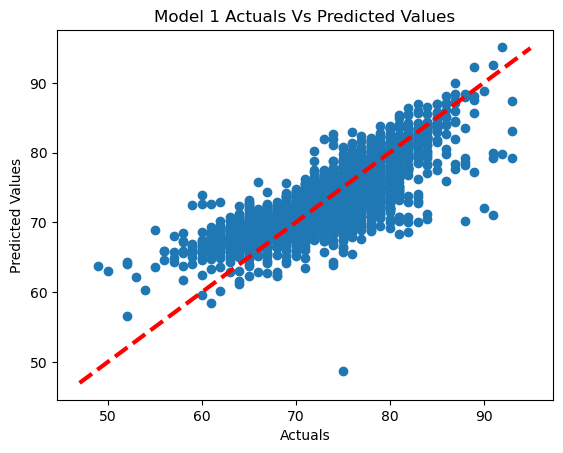

In [62]:
plt.scatter(y_test, y_pred_1)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', c='red', lw=3)
plt.xlabel('Actuals')
plt.ylabel('Predicted Values')
plt.title('Model 1 Actuals Vs Predicted Values')
plt.show()

C:\Users\pgarciag\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


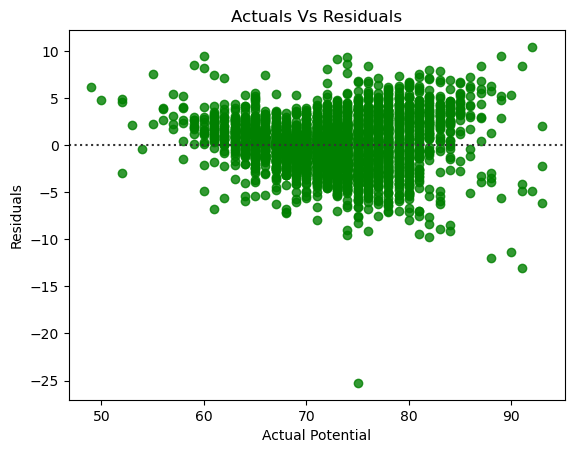

In [63]:
sns.residplot(y_test, y_pred_1, color='green')
plt.xlabel('Actual Potential')
plt.ylabel('Residuals')
plt.title('Actuals Vs Residuals')
plt.show()

#  MODEL RUN 2:
    # Numeric Data: OVA, Value and Hits
    # Categoric: W/F, Foot

In [64]:

X_train, X_test, y_train, y_test = train_test_split(combined_df2, y, test_size=0.2,random_state=100)


model2 = sm.OLS(y_train, X_train).fit()

y_pred_2 = model2.predict(X_test)

print('The accuracy of Model 2 is: ', r2_score(y_test, y_pred_2))
# print('The accuracy on the training dataset is: ', r2_score(y_train, y_pred_1))
print('The RMSE of Model 2 is: ', sqrt(mean_squared_error(y_test, y_pred_2)))
print('The MAE of Model 2 is: ', mean_absolute_error(y_test, y_pred_2))

final_df2 = concat_df(y_pred_2, df_categorical_name)
final_df2.head(500)

top_three_indices_final2 = final_df2[0].nlargest(3).index
top_three_final2 = final_df2.loc[top_three_indices_final2]
print(top_three_final2)

The accuracy of Model 2 is:  0.6275841405615918
The RMSE of Model 2 is:  3.4791213020402862
The MAE of Model 2 is:  2.6479459888451222
       const          0               1
11329    1.0  88.177272       Cucurella
2287     1.0  87.639122  R. Lewandowski
7277     1.0  87.605861         Everton


In [65]:
top_3_final2 =df[df['name'].isin(["Cucurella","R. Lewandowski","Everton"])]
top_3_final2[['name', 'age', 'ova', 'bov', 'value','hits', 'ir', 'w/f', 'foot']]

name  age  ova  bov       value   hits   ir  w/f   foot
2287   R. Lewandowski   31   91   91  80000000.0  487.0  4 ★  4 ★  Right
7277          Everton   24   81   82  24000000.0  829.0  1 ★  3 ★  Right
11329       Cucurella   21   81   82  26500000.0  959.0  1 ★  3 ★   Left

C:\Users\pgarciag\AppData\Local\Temp\ipykernel_2508\2738084782.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', c='red', lw=3)


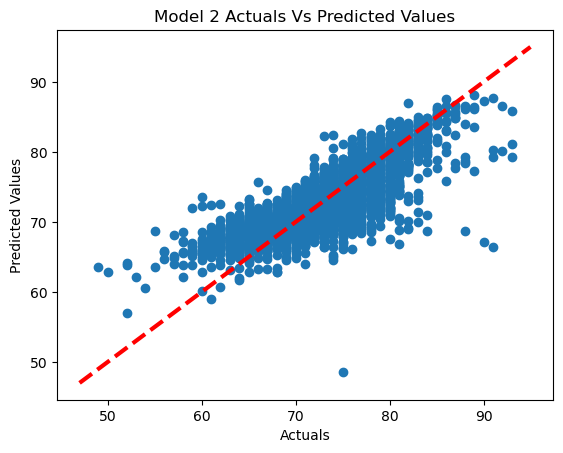

C:\Users\pgarciag\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


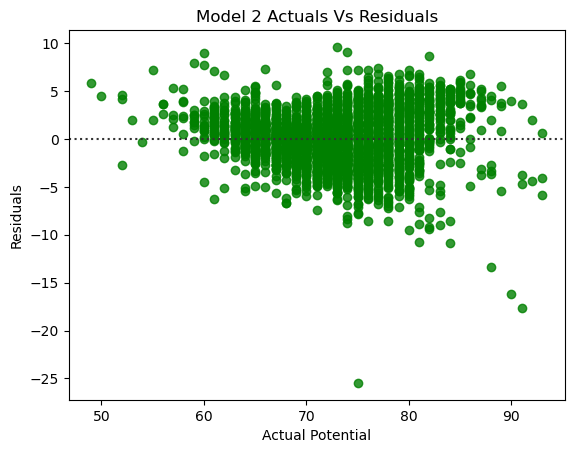

In [66]:
plt.scatter(y_test, y_pred_2)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', c='red', lw=3)
plt.xlabel('Actuals')
plt.ylabel('Predicted Values')
plt.title('Model 2 Actuals Vs Predicted Values')
plt.show()

sns.residplot(y_test, y_pred_2, color='green')
plt.xlabel('Actual Potential')
plt.ylabel('Residuals')
plt.title('Model 2 Actuals Vs Residuals')
plt.show()

# MODEL RUN 3:

#Numeric Data: OVA, Value and Hits
#Categoric: W/F, foot, ir, sm

In [67]:

X_train, X_test, y_train, y_test = train_test_split(combined_df3, y, test_size=0.2,random_state=100)


model3 = sm.OLS(y_train, X_train).fit()

y_pred_3 = model3.predict(X_test)

print('The accuracy of Model 3 is: ', r2_score(y_test, y_pred_3))
# print('The accuracy on the training dataset is: ', r2_score(y_train, y_pred_1))
print('The RMSE of Model 3 is: ', sqrt(mean_squared_error(y_test, y_pred_3)))
print('The MAE of Model 3 is: ', mean_absolute_error(y_test, y_pred_3))

final_df3 = concat_df(y_pred_3, df_categorical_name)
final_df3.head(500)

top_three_indices_final3 = final_df3[0].nlargest(3).index
top_three_final3 = final_df3.loc[top_three_indices_final3]
print(top_three_final3)

The accuracy of Model 3 is:  0.647483590441954
The RMSE of Model 3 is:  3.3848946498684853
The MAE of Model 3 is:  2.5716858137874277
      const          0                  1
142     1.0  94.237203  Cristiano Ronaldo
1010    1.0  93.486527           M. Neuer
2287    1.0  92.446547     R. Lewandowski


In [68]:
top_3_final3 =df[df['name'].isin(["Cristiano Ronaldo","M. Neuer","R. Lewandowski"])]
top_3_final3[['name', 'age', 'ova', 'bov', 'value','hits', 'ir', 'w/f', 'foot']]

name  age  ova  bov       value   hits   ir  w/f   foot
142   Cristiano Ronaldo   35   92   92  46000000.0  750.0  5 ★  4 ★  Right
1010           M. Neuer   34   89   89  29000000.0  222.0  5 ★  4 ★  Right
2287     R. Lewandowski   31   91   91  80000000.0  487.0  4 ★  4 ★  Right

C:\Users\pgarciag\AppData\Local\Temp\ipykernel_2508\1815109861.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', c='red', lw=3)


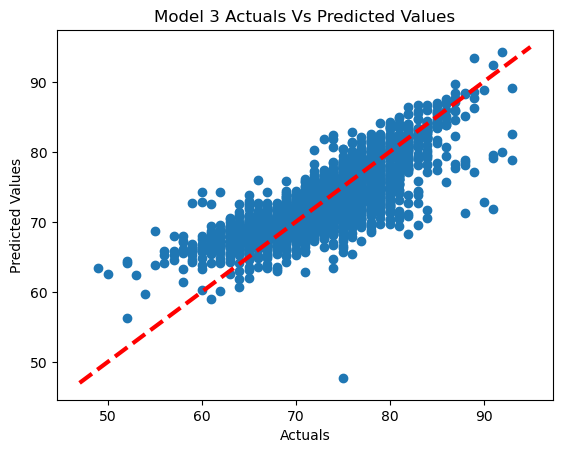

C:\Users\pgarciag\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


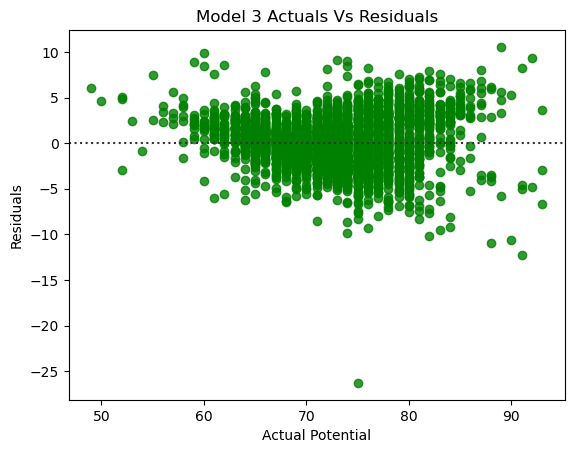

In [69]:
plt.scatter(y_test, y_pred_3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', c='red', lw=3)
plt.xlabel('Actuals')
plt.ylabel('Predicted Values')
plt.title('Model 3 Actuals Vs Predicted Values')
plt.show()

sns.residplot(y_test, y_pred_3, color='green')
plt.xlabel('Actual Potential')
plt.ylabel('Residuals')
plt.title('Model 3 Actuals Vs Residuals')
plt.show()

# MODEL RUN 4 
    # Numeric Data: OVA, Value and Hits.
    # Categoric: SM, W/F, Ir.

In [70]:

X_train, X_test, y_train, y_test = train_test_split(combined_df4, y, test_size=0.2,random_state=100)


model4 = sm.OLS(y_train, X_train).fit()

y_pred_4 = model4.predict(X_test)

print('The accuracy of Model 4 is: ', r2_score(y_test, y_pred_4))
# print('The accuracy on the training dataset is: ', r2_score(y_train, y_pred_1))
print('The RMSE of Model 4 is: ', sqrt(mean_squared_error(y_test, y_pred_4)))
print('The MAE of Model 4 is: ', mean_absolute_error(y_test, y_pred_4))

final_df4 = concat_df(y_pred_4, df_categorical_name)
final_df4.head(500)

top_three_indices_final4 = final_df4[0].nlargest(3).index
top_three_final4 = final_df4.loc[top_three_indices_final4]
print(top_three_final4)

The accuracy of Model 4 is:  0.647751083343953
The RMSE of Model 4 is:  3.383610160555663
The MAE of Model 4 is:  2.5709159352816924
      const          0                  1
142     1.0  94.276230  Cristiano Ronaldo
1010    1.0  93.486771           M. Neuer
2287    1.0  92.484246     R. Lewandowski


In [71]:
top_3_final4 =df[df['name'].isin(["Cristiano Ronaldo","M. Neuer","R. Lewandowski"])]
top_3_final4[['name', 'age', 'ova', 'bov', 'value','hits', 'ir', 'w/f', 'foot']]

name  age  ova  bov       value   hits   ir  w/f   foot
142   Cristiano Ronaldo   35   92   92  46000000.0  750.0  5 ★  4 ★  Right
1010           M. Neuer   34   89   89  29000000.0  222.0  5 ★  4 ★  Right
2287     R. Lewandowski   31   91   91  80000000.0  487.0  4 ★  4 ★  Right

C:\Users\pgarciag\AppData\Local\Temp\ipykernel_2508\398712297.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', c='red', lw=3)


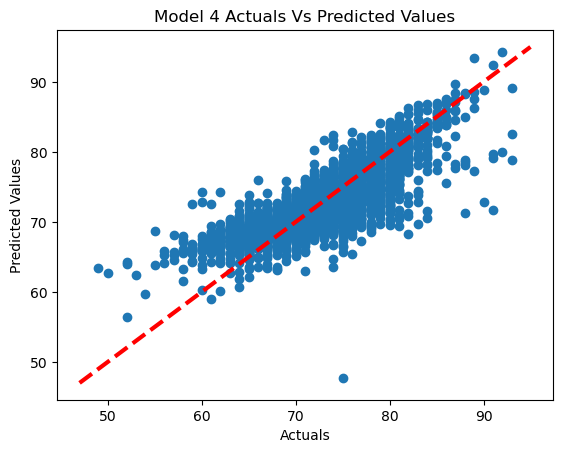

C:\Users\pgarciag\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


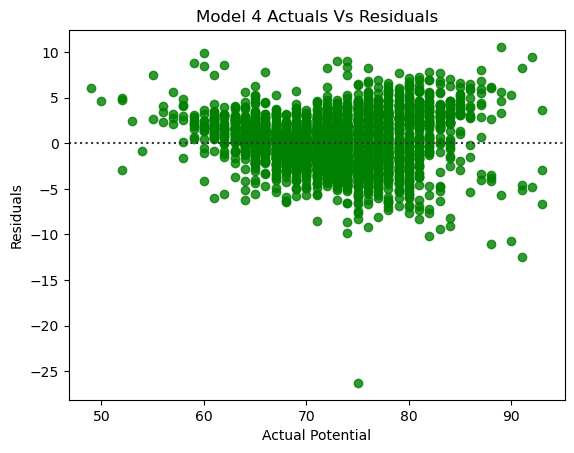

In [72]:
plt.scatter(y_test, y_pred_4)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', c='red', lw=3)
plt.xlabel('Actuals')
plt.ylabel('Predicted Values')
plt.title('Model 4 Actuals Vs Predicted Values')
plt.show()

sns.residplot(y_test, y_pred_4, color='green')
plt.xlabel('Actual Potential')
plt.ylabel('Residuals')
plt.title('Model 4 Actuals Vs Residuals')
plt.show()

In [80]:
# MODEL RUN 5 
    # Numeric Data: OVA, Value.
    # Categoric: Foot, IR, W/F, SM 

In [81]:
X_train, X_test, y_train, y_test = train_test_split(combined_df5, y, test_size=0.2,random_state=100)


model5 = sm.OLS(y_train, X_train).fit()

y_pred_5 = model5.predict(X_test)

print('The accuracy of Model 5 is: ', r2_score(y_test, y_pred_5))
# print('The accuracy on the training dataset is: ', r2_score(y_train, y_pred_1))
print('The RMSE of Model 5 is: ', sqrt(mean_squared_error(y_test, y_pred_5)))
print('The MAE of Model 5 is: ', mean_absolute_error(y_test, y_pred_5))

final_df5 = concat_df(y_pred_5, df_categorical_name)
final_df5.head(500)

top_three_indices_final5 = final_df5[0].nlargest(3).index
top_three_final5 = final_df5.loc[top_three_indices_final5]
print(top_three_final5)

The accuracy of Model 5 is:  0.5776483913047119
The RMSE of Model 5 is:  3.705037122362024
The MAE of Model 5 is:  2.9094335327864327
      const          0                  1
1010    1.0  92.843142           M. Neuer
142     1.0  92.499120  Cristiano Ronaldo
2287    1.0  91.663079     R. Lewandowski


In [82]:
# MODEL RUN 6 
    # Numeric Data: BOV, Value.
    # Categoric: IR, W/F, SM 

In [83]:
X_train, X_test, y_train, y_test = train_test_split(combined_df6, y, test_size=0.2,random_state=100)


model6 = sm.OLS(y_train, X_train).fit()

y_pred_6 = model6.predict(X_test)

print('The accuracy of Model 6 is: ', r2_score(y_test, y_pred_6))
# print('The accuracy on the training dataset is: ', r2_score(y_train, y_pred_1))
print('The RMSE of Model 6 is: ', sqrt(mean_squared_error(y_test, y_pred_6)))
print('The MAE of Model 6 is: ', mean_absolute_error(y_test, y_pred_6))

final_df6 = concat_df(y_pred_6, df_categorical_name)
final_df6.head(500)

top_three_indices_final6 = final_df6[0].nlargest(3).index
top_three_final6 = final_df6.loc[top_three_indices_final6]
print(top_three_final6)

The accuracy of Model 6 is:  0.5508449353328391
The RMSE of Model 6 is:  3.8207941303977293
The MAE of Model 6 is:  3.0559992532770086
      const          0                  1
142     1.0  93.107524  Cristiano Ronaldo
1010    1.0  92.499665           M. Neuer
2287    1.0  91.440556     R. Lewandowski


In [84]:
# MODEL RUN 7 
    # Numeric Data: BOV, Value, Hits.
    # Categoric: IR, W/F, SM 

In [85]:
X_train, X_test, y_train, y_test = train_test_split(combined_df7, y, test_size=0.2,random_state=100)


model7 = sm.OLS(y_train, X_train).fit()

y_pred_7 = model7.predict(X_test)

print('The accuracy of Model 7 is: ', r2_score(y_test, y_pred_7))
# print('The accuracy on the training dataset is: ', r2_score(y_train, y_pred_1))
print('The RMSE of Model 7 is: ', sqrt(mean_squared_error(y_test, y_pred_7)))
print('The MAE of Model 7 is: ', mean_absolute_error(y_test, y_pred_7))

final_df7 = concat_df(y_pred_7, df_categorical_name)
final_df7.head(500)

top_three_indices_final7 = final_df7[0].nlargest(3).index
top_three_final7 = final_df7.loc[top_three_indices_final6]
print(top_three_final7)

The accuracy of Model 7 is:  0.6368310066804962
The RMSE of Model 7 is:  3.4356575464775934
The MAE of Model 7 is:  2.640267333468521
      const          0                  1
142     1.0  94.769697  Cristiano Ronaldo
1010    1.0  93.327405           M. Neuer
2287    1.0  92.411926     R. Lewandowski
